(ordinal_regression)=
# Regression Models with Ordered Categorical Outcomes

:::{post} April, 2023
:tags: ordinal regression, generalized linear model, 
:category: beginner, reference
:author: Nathaniel Forde
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import statsmodels.api as sm

from scipy.stats import bernoulli
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

# Ordinal Scales and Survey Data

Like many areas of statistics the language of survey data comes with an overloaded vocabulary. When discussing survey design you will often hear about the contrast between *design* based and *model* based approaches to (i) sampling strategies and (ii) statistical inference on the associated data. We won't wade into the details about different sample strategies such as: simple random sampling, cluster random sampling or stratified random sampling using population weighting schemes. The literature on each of these is vast, but in this notebook we'll talk about when any why it's useful to apply model driven statistical inference to Likert scaled survey response data and other kinds of ordered categorical data. 


## Ordered Categories: Known Distribution

We'll start by generating some fake data. Imagine an employee/manager relationship where part of the annual process involves conducting a 360 degree review. The manager gets a rating (1 - 10) by their team and HR collects these ratings. The HR manager wants to know which factors influence the manager's rating and what can move a manager who receives a 4 into a 5 or a 7 into an 8. They have a theory that the rating is largely a function of salary. 

Ordinal Regression is a statistical technique designed to **model** these kinds of relationships and can be contrasted to a design based approach where the focus is to extract simple statistical summaries e.g. proportions, counts or ratios in the context of a survey design under strong guarantees about the error tolerance in those derived summaries.

In [3]:
def make_data():
    salary = np.random.normal(40, 10, 500)
    work_sat = np.random.beta(1, 0.4, 500)
    work_from_home = bernoulli.rvs(0.7, size=500)
    work_from_home_calc = np.where(work_from_home, 1.4 * work_from_home, work_from_home)
    latent_rating = (
        0.08423 * salary + 0.2 * work_sat + work_from_home_calc + np.random.normal(0, 1, 500)
    )
    explicit_rating = np.round(latent_rating, 0)
    df = pd.DataFrame(
        {
            "salary": salary,
            "work_sat": work_sat,
            "work_from_home": work_from_home,
            "latent_rating": latent_rating,
            "explicit_rating": explicit_rating,
        }
    )
    return df


try:
    df = pd.read_csv("../data/fake_employee_manger_rating.csv")
except FileNotFoundError:
    df = make_data()

K = len(df["explicit_rating"].unique())
df.head()

Unnamed: 0     salary  work_sat  work_from_home  latent_rating  \
0           0  41.172474  0.632002               1       5.328188   
1           1  40.984524  0.904452               0       3.198263   
2           2  36.469472  0.911330               1       4.108042   
3           3   6.453822  0.919106               0       1.496440   
4           4  33.795497  0.894581               0       3.200672   

   explicit_rating  
0              5.0  
1              3.0  
2              4.0  
3              1.0  
4              3.0

We've specified our data in such a way that there is an underlying latent sentiment which is continuous in scale that gets crudely discretised to represent the ordinal rating scale. We've specified the data in such a way that salary drives a fairly linear increase in the manager's rating. 

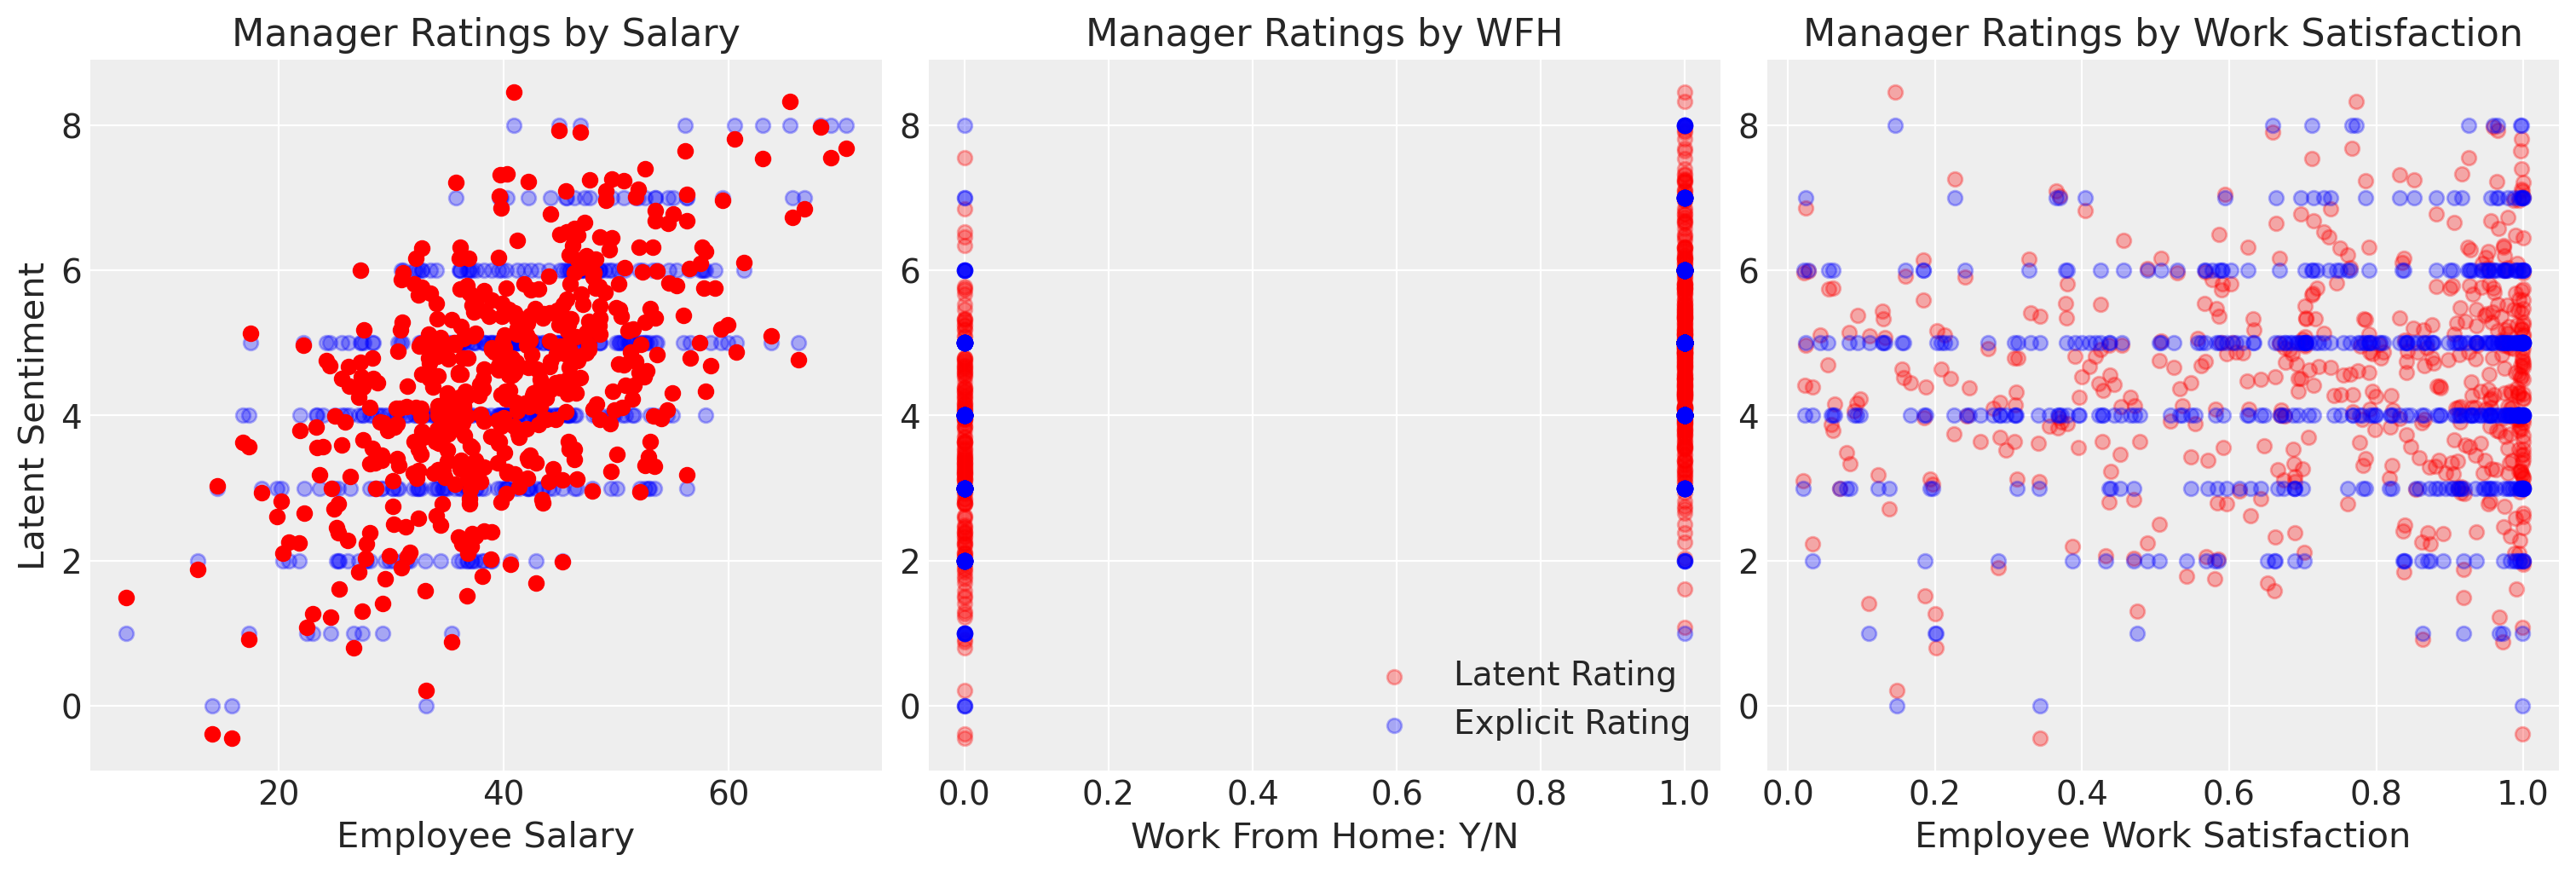

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
ax = axs[0]
ax.scatter(df["salary"], df["explicit_rating"], label="Explicit Rating", color="blue", alpha=0.3)
axs[1].scatter(
    df["work_from_home"], df["latent_rating"], label="Latent Rating", color="red", alpha=0.3
)
axs[1].scatter(
    df["work_from_home"], df["explicit_rating"], label="Explicit Rating", c="blue", alpha=0.3
)
axs[2].scatter(df["work_sat"], df["latent_rating"], label="Latent Rating", color="red", alpha=0.3)
axs[2].scatter(
    df["work_sat"], df["explicit_rating"], label="Explicit Rating", color="blue", alpha=0.3
)
ax.scatter(df["salary"], df["latent_rating"], label="Latent Sentiment", color="red")
ax.set_title("Manager Ratings by Salary")
axs[1].set_title("Manager Ratings by WFH")
axs[2].set_title("Manager Ratings by Work Satisfaction")
ax.set_ylabel("Latent Sentiment")
ax.set_xlabel("Employee Salary")
axs[1].set_xlabel("Work From Home: Y/N")
axs[2].set_xlabel("Employee Work Satisfaction")
axs[1].legend();

We can see here however that if we fit this model with a simple OLS fit it implies values beyond the categorical scale, which might motivate spurious salary increases by an overzealous HR manager. The OLS approximation is limited in that it cannot account for the proper nature of the outcome variable. 

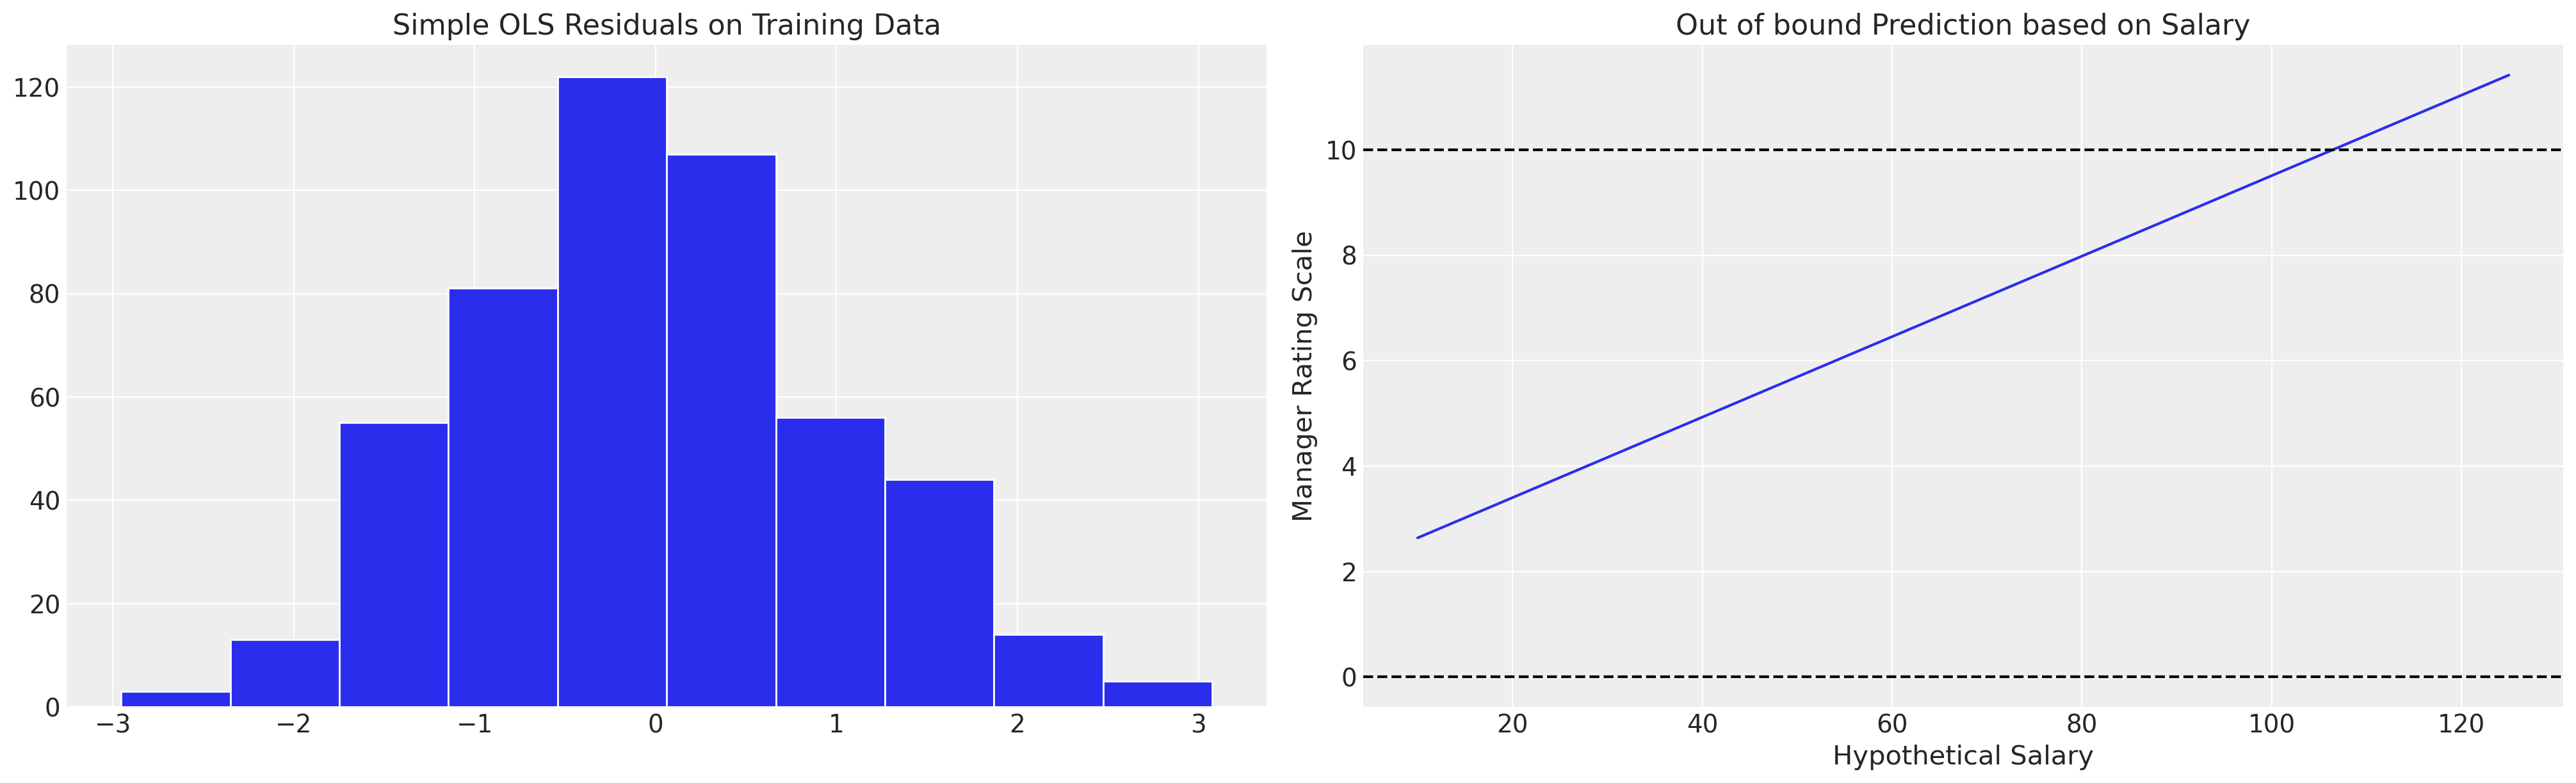

In [5]:
exog = sm.add_constant(df[["salary", "work_from_home", "work_sat"]])
mod = sm.OLS(df["explicit_rating"], exog)
results = mod.fit()
results.summary()

results.predict([1, 200, 1, 0.6])
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
ax = axs[1]
salaries = np.linspace(10, 125, 20)
predictions = [results.predict([1, i, 1, 0.6])[0] for i in salaries]
ax.plot(salaries, predictions, label="Implied Linear function of Salaries on Outcome")
ax.set_title("Out of bound Prediction based on Salary")
ax.axhline(10, linestyle="--", color="black")
ax.set_xlabel("Hypothetical Salary")
ax.set_ylabel("Manager Rating Scale")
ax.axhline(0, linestyle="--", color="black")
axs[0].hist(results.resid, ec="white")
axs[0].set_title("Simple OLS Residuals on Training Data");

This suggests a reason for the contrast between *design* and *model* based approaches to inference with survey data. The modelling approach often hides or buries assumptions which makes the model infeasible, and the conservative approach tends towards inference under a design philosophy that avoids the risk of model misspecification. 

## Ordinal Regression Models: The Idea

In this notebook we'll show how to fit regression models to outcomes with ordered categories to avoid one type of model misspecification. These types of models can be considered as an application logistic regression models with multiple thresholds on a latent continuous scale. The idea is that there is a latent metric which can be partitioned by the extremity of the measure, but we observe only the indicator for which partition of the scale an individual resides. This is quite a natural perspective e.g. imagine the bundling of complexity that gets hidden in crude political classifications: liberal, moderate and conservative. You may have a range of views on any number of political issues, but they all get collapsed in the political calculus to finite set of (generally poor) choices. Which of the last 10 political choices pushed you from liberal to moderate?


The idea is to treat the outcome variable (our categorical) judgment as deriving from an underlying continuous measure. We see the outcomes we do just when some threshold on that continuous measure has been achieved. The primary inferential task of ordinal regression is to derive an estimate of those thresholds in the latent continuous space. 

In the data set above we've explicitly specified the relationship, and in the following steps we'll estimate a variety of ordinal regression models.


## Fit a variety of Model Specifications

The model specification for ordinal regression models typically makes use of the the logit transformation and the cumulative probabilities implied. For $c$ outcome categories with probabilities $\pi_1, .... \pi_n$ the *cumulative logits* are defined:

$$ logit[P(Y \leq j)]  = log \frac{P(Y \leq j)}{1 - p(Y \leq j)}  = log \frac{\pi_1 + ... + \pi_j}{\pi_{j+1} + ... + \pi_n} \text{ where  j = 1, ..., c-1} $$

This gets employed in a regression context where we specify the factors which determine our latent outcome in a linear fashion:

$$ logit[P(Y \leq j)] = \alpha_{j} + \beta'x $$

which implies that:

$$ P(Y \leq j) = \frac{exp(\alpha_{j} + \beta'x)}{1 + exp(\alpha_{j} + \beta'x)} $$

and that the probability for belonging within a particular category $j$ is determined by the probability of being in the cell defined by: 

$$ P(Y = j) = \frac{exp(\alpha_{j} + \beta'x)}{1 + exp(\alpha_{j} + \beta'x)} - \frac{exp(\alpha_{j-1} + \beta'x)}{1 + exp(\alpha_{j-1} + \beta'x)} $$

One nice feature of ordinal regressions specified in this fashion is that the interpretation of the coefficients on the beta terms remain the same across each interval on the latent space. The interpretaiton of the model parameters is typical: a unit increase in $x_{k}$ corresponds to an increase in $Y_{latent}$ of $\beta_{k}$ Similar interpretation holds for probit regression specification too. However we must be careful about comparing the interpretation of coefficients across different model specifications with different variables. The above coefficient interpretation makes sense as conditional interpretation based on holding fixed precisely the variables in the model. Adding or removing variables changes the conditionalisation which breaks the comparability of the models due the phenomena of non-collapsability. We'll show below how it's better to compare the models on their predictive implications using the posterior predictive distribution. 

### Bayesian Particularities 

While Ordinal regression is often performed in a frequentist paradigm, the same techniques can be applied in a Bayesian setting with all the benefits of posterior probability distributions and posterior predictive simulations. In PyMC there are at least two ways we can go about specifying the priors over the this model. The first one uses a constrained Dirichlet distribution to define a prior over the thresholds. The second method, a little looser allows the specification of any prior distribution with suitable number of cutpoints applying a ordering transformation on the generated samples from the prior distribution. 

We'll show both in this notebook, but as we'll see, the definition of the Dirchlet ensures properties which make it a better fit for the constrained outcome space. In each approach we can include covariates as in more standard regression models. 

PyMC has both `OrderedLogistic` and `OrderedProbit` distributions available. 

In [6]:
def constrainedUniform(N, min=0, max=1):
    return pm.Deterministic(
        "cutpoints",
        pt.concatenate(
            [
                np.ones(1) * min,
                pt.extra_ops.cumsum(pm.Dirichlet("cuts_unknown", a=np.ones(N - 2)))
                * (min + (max - min)),
            ]
        ),
    )

The above function, (brainchild of Dr Ben Vincent), looks a little indimidating, but it's just a convenience function to specify a prior over the cutpoints in our $Y_{latent}$. The Dirichlet distribution is special in that draws from the distribution must sum to one. The above function ensures that each draw from the prior distribution is a cumulative share of the maximum category greater than the minimum of our ordinal categorisation. 

In [7]:
def make_model(priors, model_spec=1, constrained_uniform=False, logit=True):
    with pm.Model() as model:

        if constrained_uniform:
            cutpoints = constrainedUniform(K, 0, K)
        else:
            sigma = pm.Exponential("sigma", priors["sigma"])
            cutpoints = pm.Normal(
                "cutpoints",
                mu=priors["mu"],
                sigma=sigma,
                transform=pm.distributions.transforms.univariate_ordered,
            )

        if model_spec == 1:
            beta = pm.Normal("beta", priors["beta"][0], priors["beta"][1], size=1)
            mu = pm.Deterministic("mu", beta[0] * df.salary)
        elif model_spec == 2:
            beta = pm.Normal("beta", priors["beta"][0], priors["beta"][1], size=2)
            mu = pm.Deterministic("mu", beta[0] * df.salary + beta[1] * df.work_sat)
        elif model_spec == 3:
            beta = pm.Normal("beta", priors["beta"][0], priors["beta"][1], size=3)
            mu = pm.Deterministic(
                "mu", beta[0] * df.salary + beta[1] * df.work_sat + beta[2] * df.work_from_home
            )
        if logit:
            y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=mu, observed=df.explicit_rating)
        else:
            y_ = pm.OrderedProbit("y", cutpoints=cutpoints, eta=mu, observed=df.explicit_rating)
        idata = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata, model


priors = {"sigma": 1, "beta": [0, 1], "mu": np.linspace(0, K, K - 1)}
idata1, model1 = make_model(priors, model_spec=1)
idata2, model2 = make_model(priors, model_spec=2)
idata3, model3 = make_model(priors, model_spec=3)
idata4, model4 = make_model(priors, model_spec=3, constrained_uniform=True)
idata5, model5 = make_model(priors, model_spec=3, constrained_uniform=True)

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.423170
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:05.336122
Transforming variables...
Transformation time =  0:00:00.443579
Computing Log Likelihood...


/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.554627
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:05.336972
Transforming variables...
Transformation time =  0:00:00.254458
Computing Log Likelihood...


/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.606530
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:07.144061
Transforming variables...
Transformation time =  0:00:00.184754
Computing Log Likelihood...


/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.669445
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.088291
Transforming variables...
Transformation time =  0:00:00.335066
Computing Log Likelihood...


/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.578299
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.559681
Transforming variables...
Transformation time =  0:00:00.201078
Computing Log Likelihood...


In [8]:
az.summary(idata3, var_names=["sigma", "cutpoints", "beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma          2.033  0.623   1.021    3.178      0.012    0.008    2779.0   
cutpoints[0]  -1.636  0.793  -3.165   -0.151      0.014    0.011    3097.0   
cutpoints[1]   1.258  0.473   0.431    2.178      0.008    0.005    3980.0   
cutpoints[2]   3.387  0.446   2.602    4.263      0.008    0.005    3412.0   
cutpoints[3]   5.065  0.468   4.147    5.889      0.009    0.006    2907.0   
cutpoints[4]   6.879  0.513   5.930    7.821      0.010    0.007    2625.0   
cutpoints[5]   8.755  0.561   7.748    9.803      0.011    0.008    2486.0   
cutpoints[6]  10.331  0.605   9.222   11.454      0.012    0.008    2544.0   
cutpoints[7]  12.300  0.718  10.999   13.658      0.014    0.010    2728.0   
beta[0]        0.130  0.010   0.111    0.149      0.000    0.000    3004.0   
beta[1]       -0.092  0.271  -0.609    0.395      0.004    0.004    4814.0   
beta[2]        2.499  0.206   2.116    2.889      0.004    0.002    3423.0   

              ess_tail  r_hat  
sigma           3175.0    1.0  
cutpoints[0]    2330.0    1.0  
cutpoints[1]    3164.0    1.0  
cutpoints[2]    3427.0    1.0  
cutpoints[3]    3362.0    1.0  
cutpoints[4]    3091.0    1.0  
cutpoints[5]    2896.0    1.0  
cutpoints[6]    2863.0    1.0  
cutpoints[7]    3241.0    1.0  
beta[0]         2984.0    1.0  
beta[1]         2856.0    1.0  
beta[2]         2870.0    1.0

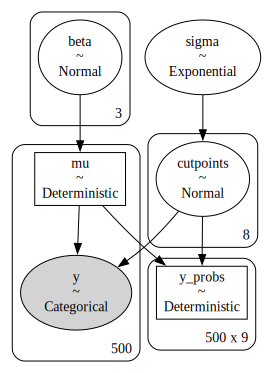

In [9]:
pm.model_to_graphviz(model3)

### Extracting Individual Probabilities 

We can now for each individual manager's rating, look at the probability associated with each of the available categories. Across the posterior distributions of our cuts which section of the latent continous measure the employee is most likely to fall into.

In [10]:
implied_probs = az.extract(idata3, var_names=["y_probs"])
implied_probs.shape

(500, 9, 4000)

In [11]:
implied_probs[0].mean(axis=1)

<xarray.DataArray 'y_probs' (y_probs_dim_1: 9)>
array([1.11580396e-04, 1.47118769e-03, 1.09436873e-02, 5.00984257e-02,
       2.25936127e-01, 4.35759906e-01, 2.01906609e-01, 6.22547104e-02,
       1.15177666e-02])
Coordinates:
    y_probs_dim_0  int64 0
  * y_probs_dim_1  (y_probs_dim_1) int64 0 1 2 3 4 5 6 7 8

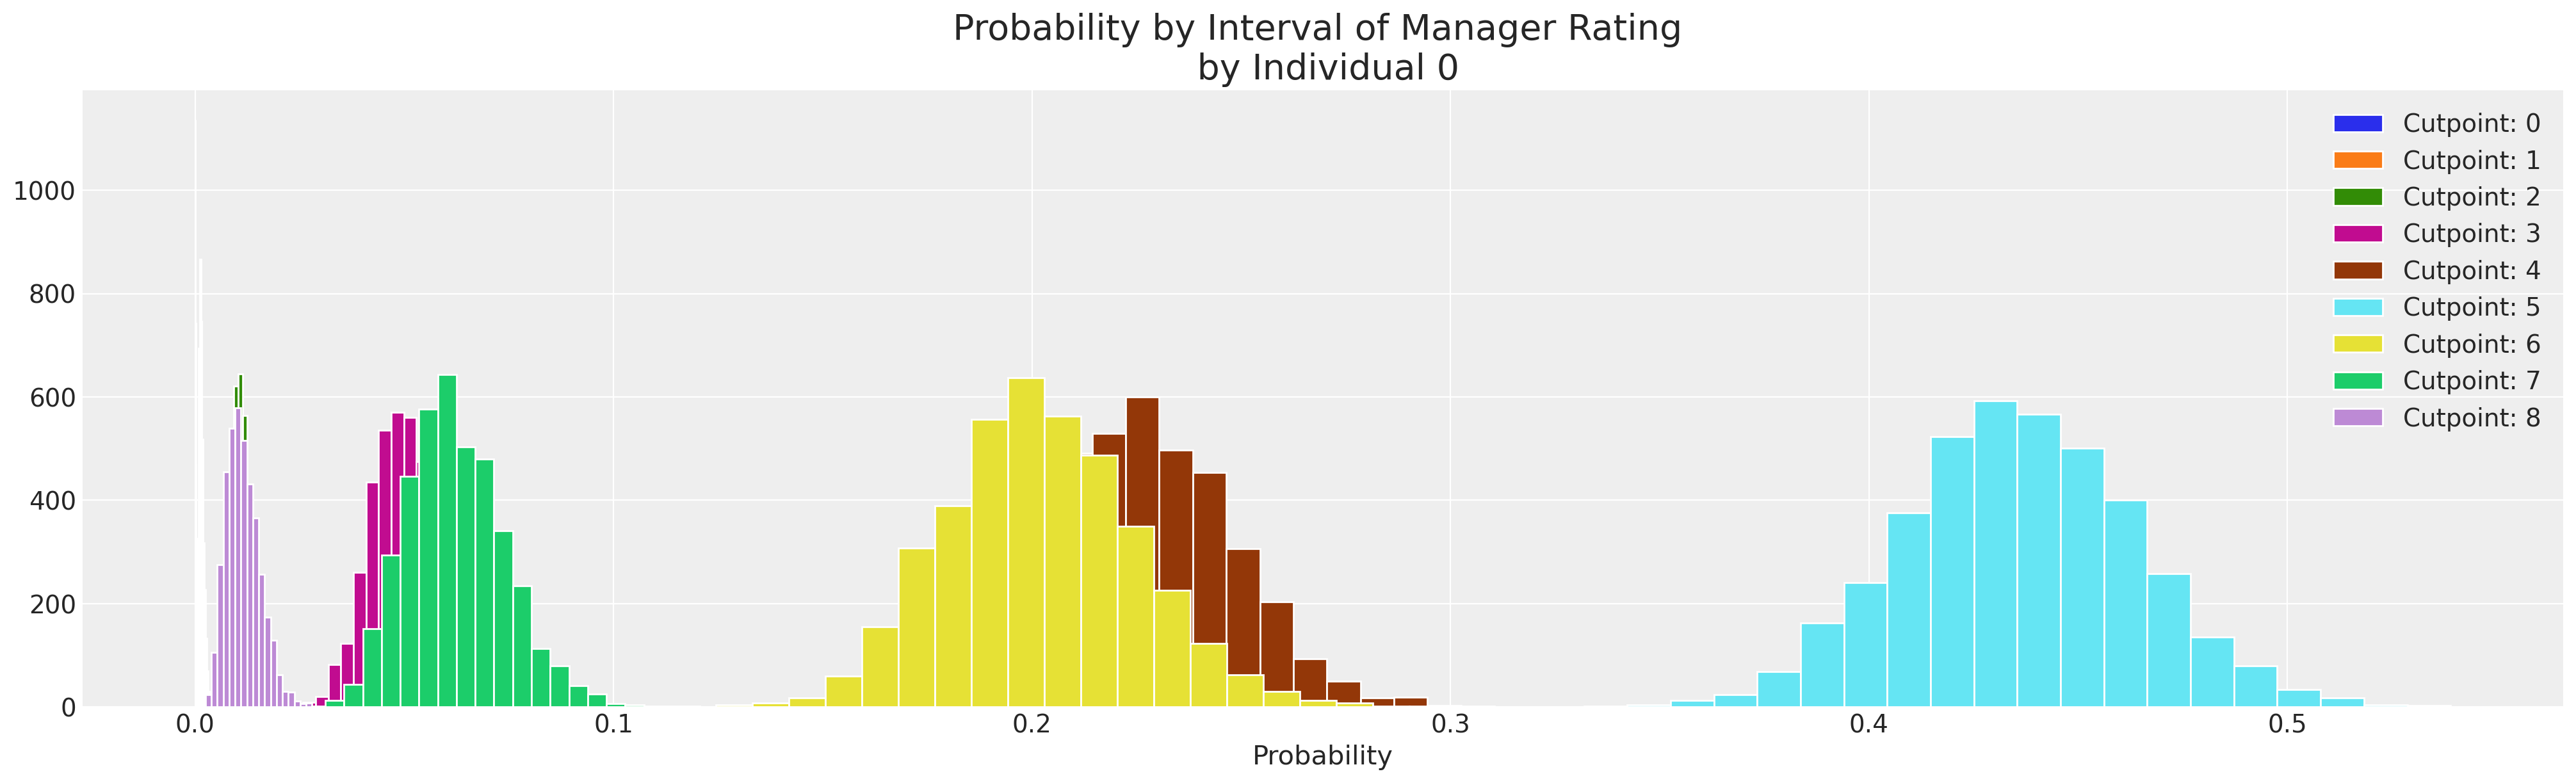

In [12]:
fig, ax = plt.subplots(figsize=(20, 6))
for i in range(K):
    ax.hist(implied_probs[0, i, :], label=f"Cutpoint: {i}", ec="white", bins=20)
ax.set_xlabel("Probability")
ax.set_title("Probability by Interval of Manager Rating \n by Individual 0", fontsize=20)
ax.legend();

In [13]:
implied_class = az.extract(idata3, var_names=["y"], group="posterior_predictive")
implied_class.shape

(500, 4000)

In [14]:
from scipy.stats import mode

mode(implied_class[0])

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_60391/3774112.py:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode(implied_class[0])


ModeResult(mode=array([5]), count=array([1733]))

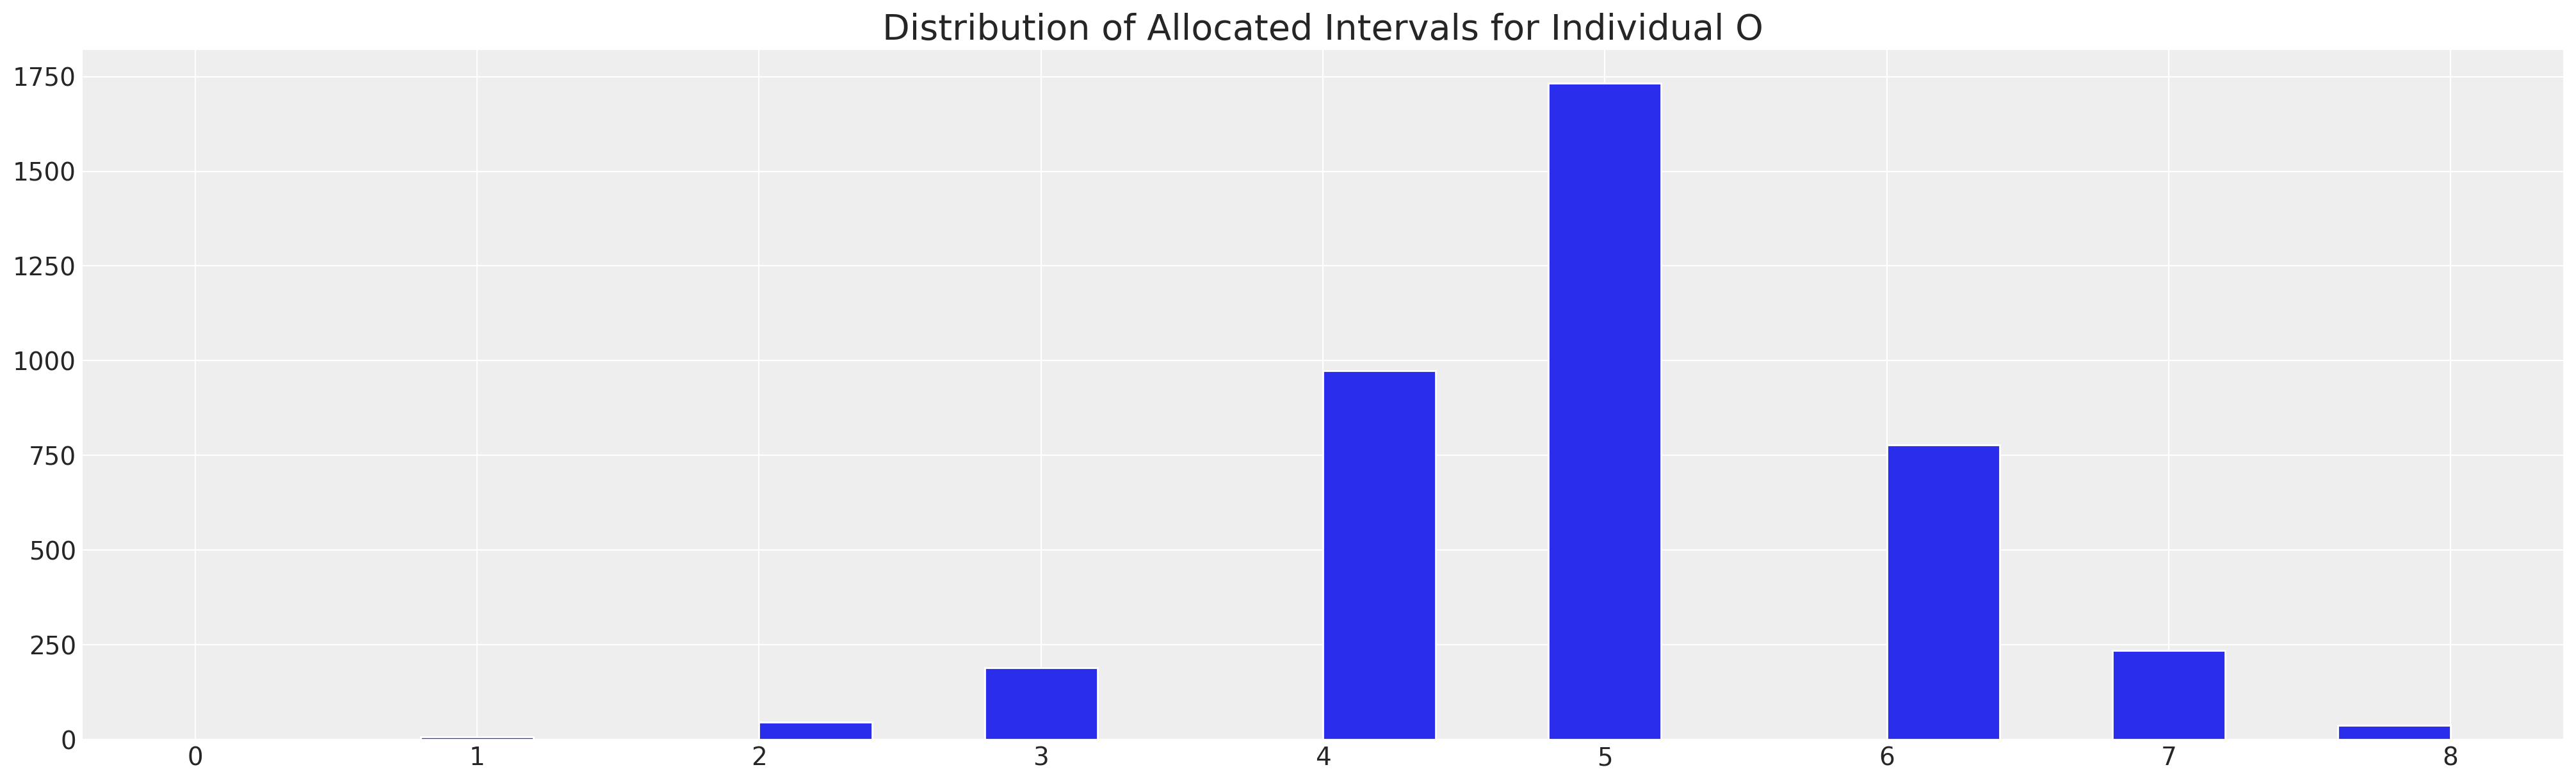

In [15]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist(implied_class[0], ec="white", bins=20)
ax.set_title("Distribution of Allocated Intervals for Individual O", fontsize=20);

## Compare Models: Parameter Fits and LOO

One tool for ameliorating the risk of model misspecification is to compare amongst different candidate model to check for  predictive accuracy. 

rank    elpd_loo      p_loo  elpd_diff        weight  \
model_full                  0 -738.046527  11.497004   0.000000  8.129532e-01   
constrained_probit_full     1 -749.123611   7.625215  11.077084  1.870468e-01   
constrained_logit_full      2 -749.383090   7.867699  11.336563  0.000000e+00   
model_salary                3 -825.547487   8.296812  87.500960  0.000000e+00   
model_salary_worksat        4 -826.424990   9.269451  88.378463  1.110223e-15   

                                se        dse  warning scale  
model_full               16.644463   0.000000    False   log  
constrained_probit_full  12.727615   6.732815    False   log  
constrained_logit_full   12.742195   6.737218    False   log  
model_salary             15.938986  12.486093    False   log  
model_salary_worksat     15.880989  12.468221    False   log

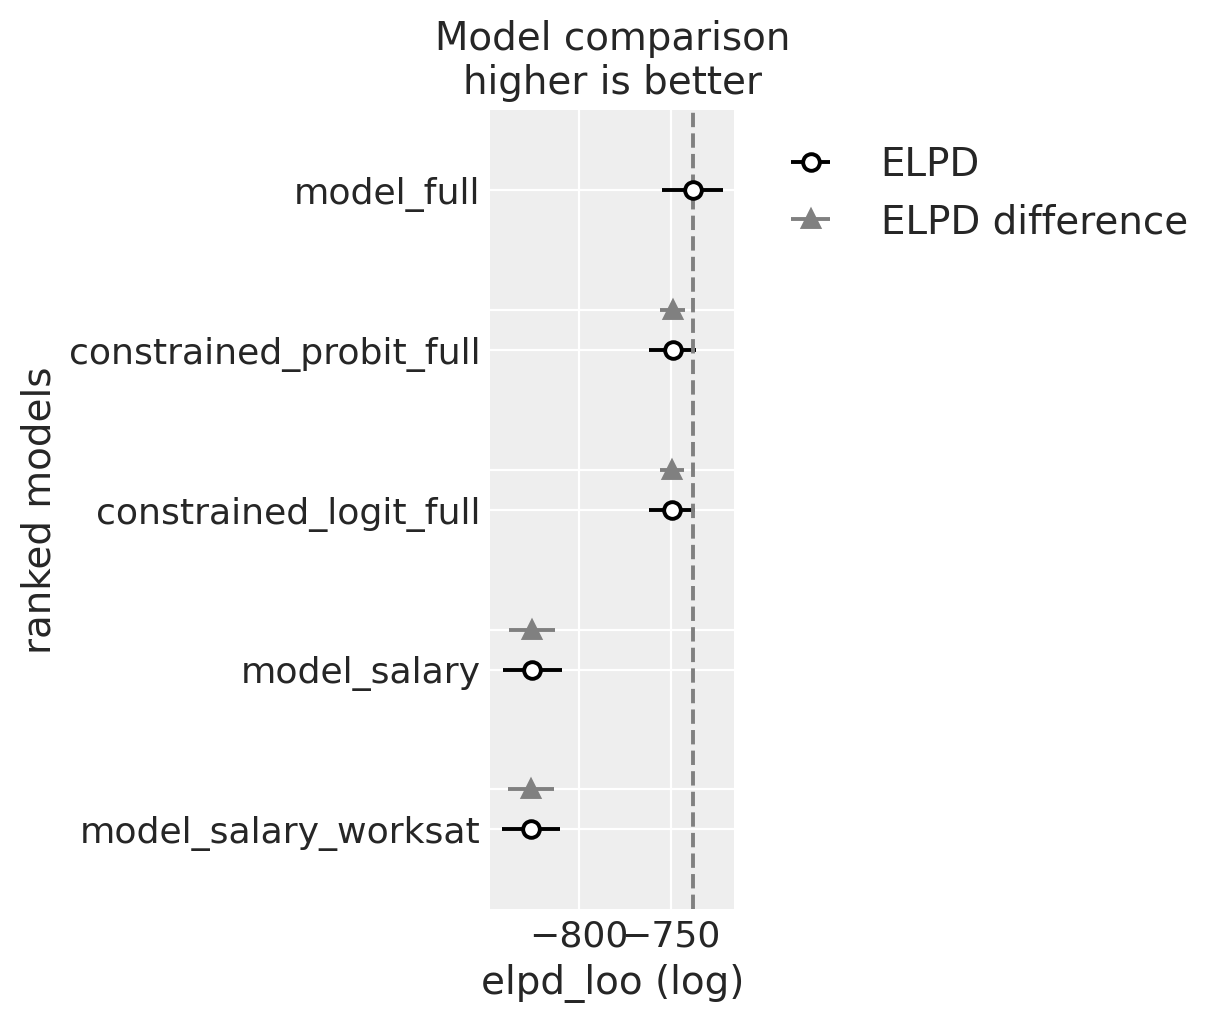

In [16]:
compare = az.compare(
    {
        "model_salary": idata1,
        "model_salary_worksat": idata2,
        "model_full": idata3,
        "constrained_logit_full": idata4,
        "constrained_probit_full": idata5,
    }
)

az.plot_compare(compare)
compare

We can also compare the estimated parameters which govern each regression model to see how robust our model fit is to alternative parameterisation. 

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


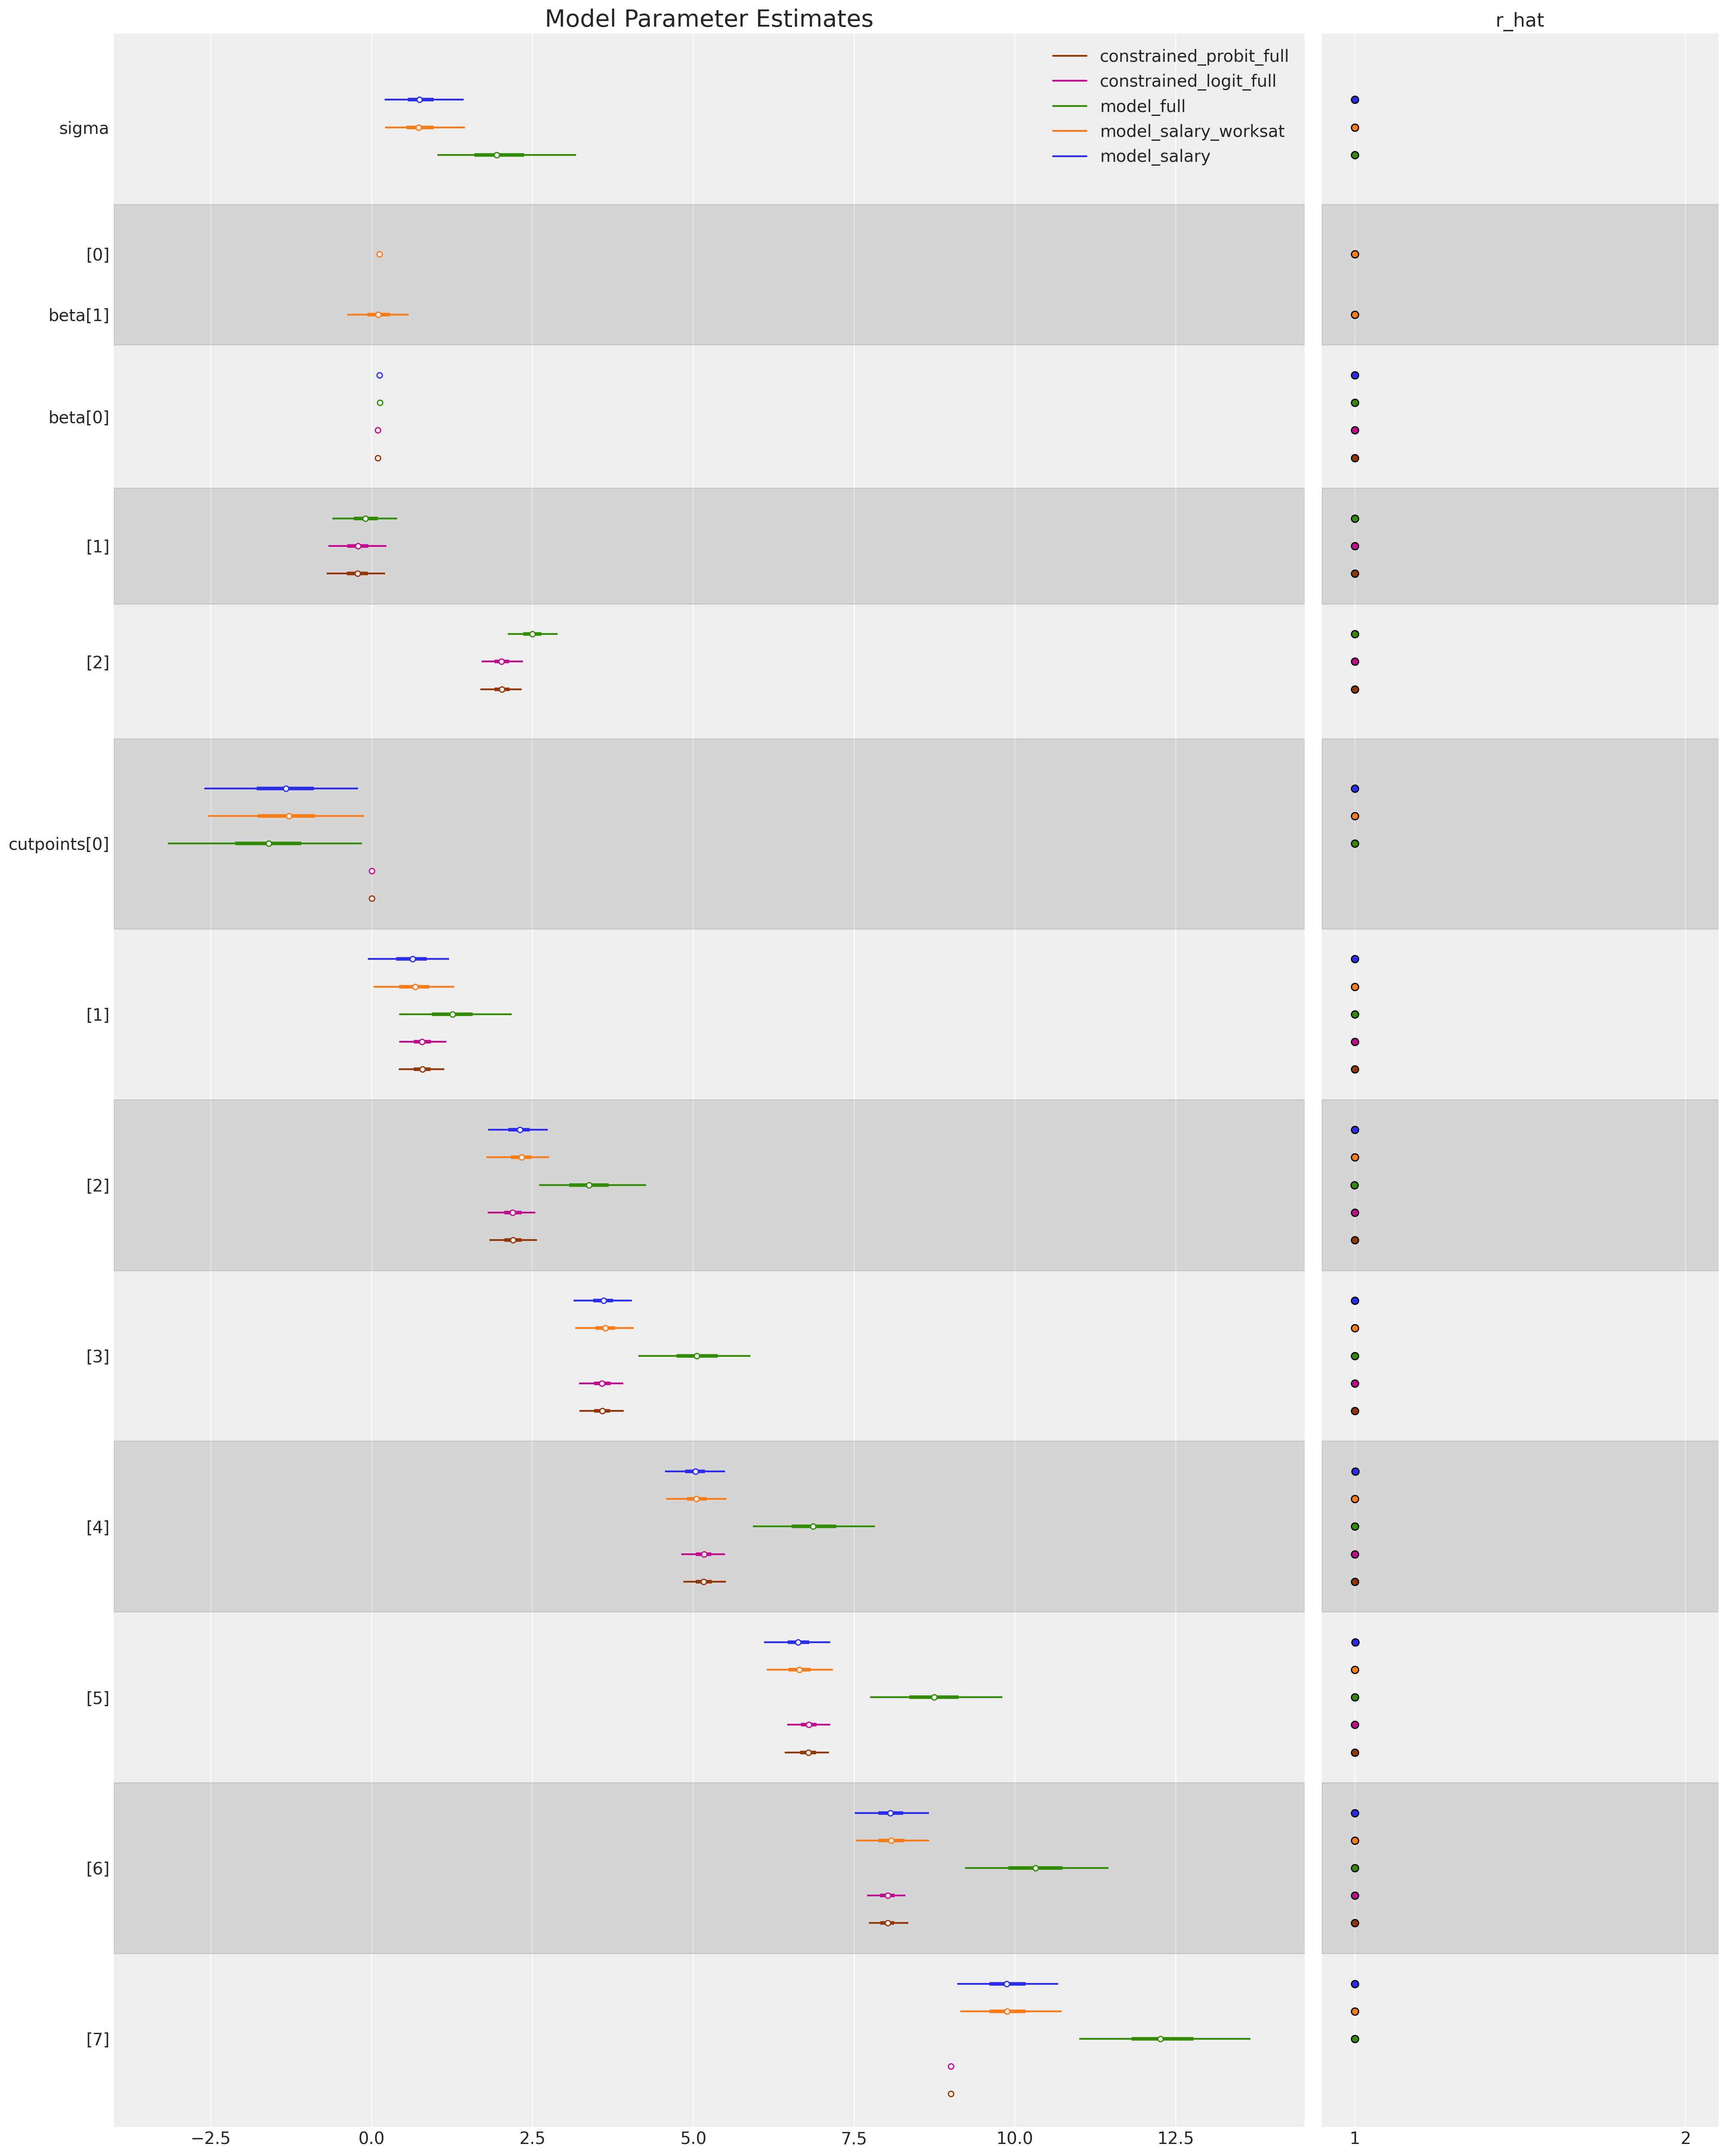

In [17]:
ax = az.plot_forest(
    [idata1, idata2, idata3, idata4, idata5],
    var_names=["sigma", "beta", "cutpoints"],
    combined=True,
    ridgeplot_overlap=4,
    figsize=(20, 25),
    r_hat=True,
    ridgeplot_alpha=0.3,
    model_names=[
        "model_salary",
        "model_salary_worksat",
        "model_full",
        "constrained_logit_full",
        "constrained_probit_full",
    ],
)
ax[0].set_title("Model Parameter Estimates", fontsize=20);

In [18]:
az.summary(idata3, var_names=["cutpoints", "beta", "sigma"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
cutpoints[0]  -1.636  0.793  -3.165   -0.151      0.014    0.011    3097.0   
cutpoints[1]   1.258  0.473   0.431    2.178      0.008    0.005    3980.0   
cutpoints[2]   3.387  0.446   2.602    4.263      0.008    0.005    3412.0   
cutpoints[3]   5.065  0.468   4.147    5.889      0.009    0.006    2907.0   
cutpoints[4]   6.879  0.513   5.930    7.821      0.010    0.007    2625.0   
cutpoints[5]   8.755  0.561   7.748    9.803      0.011    0.008    2486.0   
cutpoints[6]  10.331  0.605   9.222   11.454      0.012    0.008    2544.0   
cutpoints[7]  12.300  0.718  10.999   13.658      0.014    0.010    2728.0   
beta[0]        0.130  0.010   0.111    0.149      0.000    0.000    3004.0   
beta[1]       -0.092  0.271  -0.609    0.395      0.004    0.004    4814.0   
beta[2]        2.499  0.206   2.116    2.889      0.004    0.002    3423.0   
sigma          2.033  0.623   1.021    3.178      0.012    0.008    2779.0   

              ess_tail  r_hat  
cutpoints[0]    2330.0    1.0  
cutpoints[1]    3164.0    1.0  
cutpoints[2]    3427.0    1.0  
cutpoints[3]    3362.0    1.0  
cutpoints[4]    3091.0    1.0  
cutpoints[5]    2896.0    1.0  
cutpoints[6]    2863.0    1.0  
cutpoints[7]    3241.0    1.0  
beta[0]         2984.0    1.0  
beta[1]         2856.0    1.0  
beta[2]         2870.0    1.0  
sigma           3175.0    1.0

## Compare Cutpoints: Normal V Uniform Priors

Note how the model with unconstrianed cutpoints allows the occurence of a threshold estimated to be below zero. This does not make much conceptual sense, but can lead to a plausible enough posterior predictive distribution.

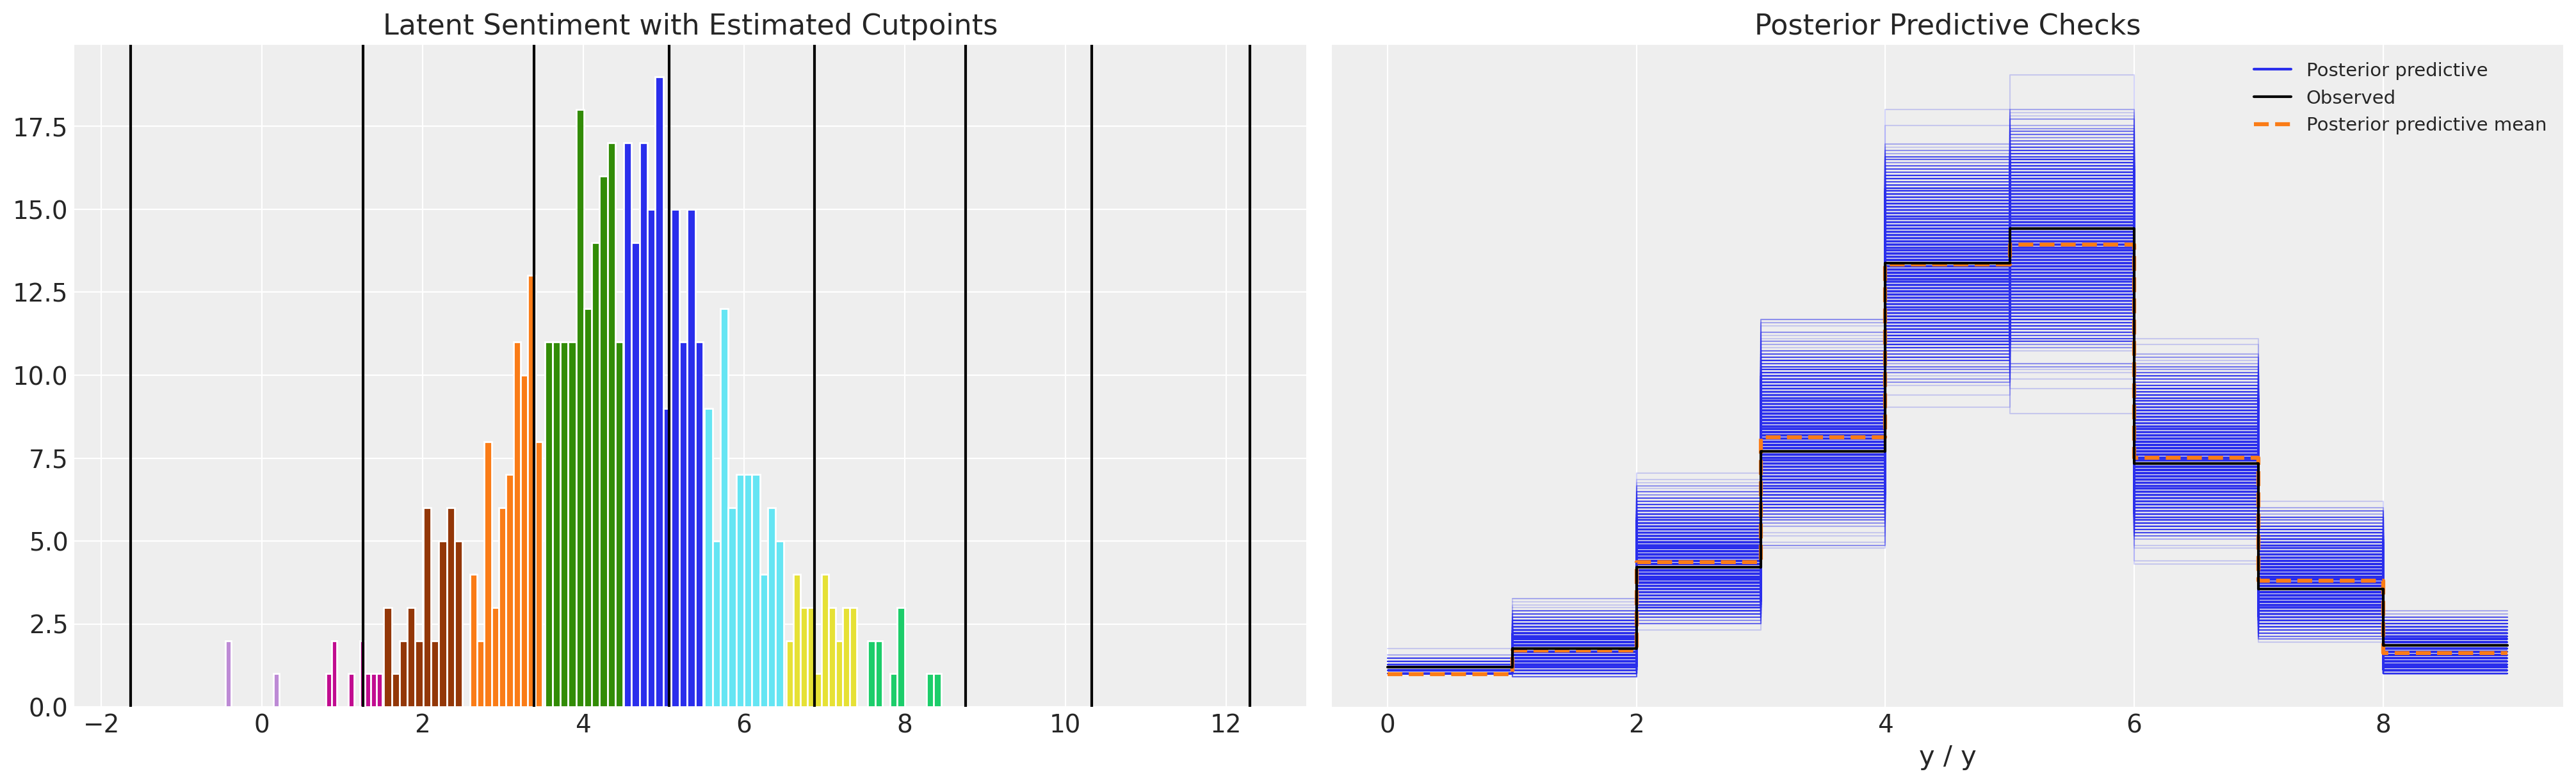

In [19]:
def plot_fit(idata):
    posterior = idata.posterior.stack(sample=("chain", "draw"))
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    axs = axs.flatten()
    ax = axs[0]
    for i in range(K - 1):
        ax.axvline(posterior["cutpoints"][i].mean().values, color="k")
    for r in df["explicit_rating"].unique():
        temp = df[df["explicit_rating"] == r]
        ax.hist(temp["latent_rating"], ec="white")
    ax.set_title("Latent Sentiment with Estimated Cutpoints")
    axs[1].set_title("Posterior Predictive Checks")
    az.plot_ppc(idata, ax=axs[1])
    plt.show()


plot_fit(idata3)

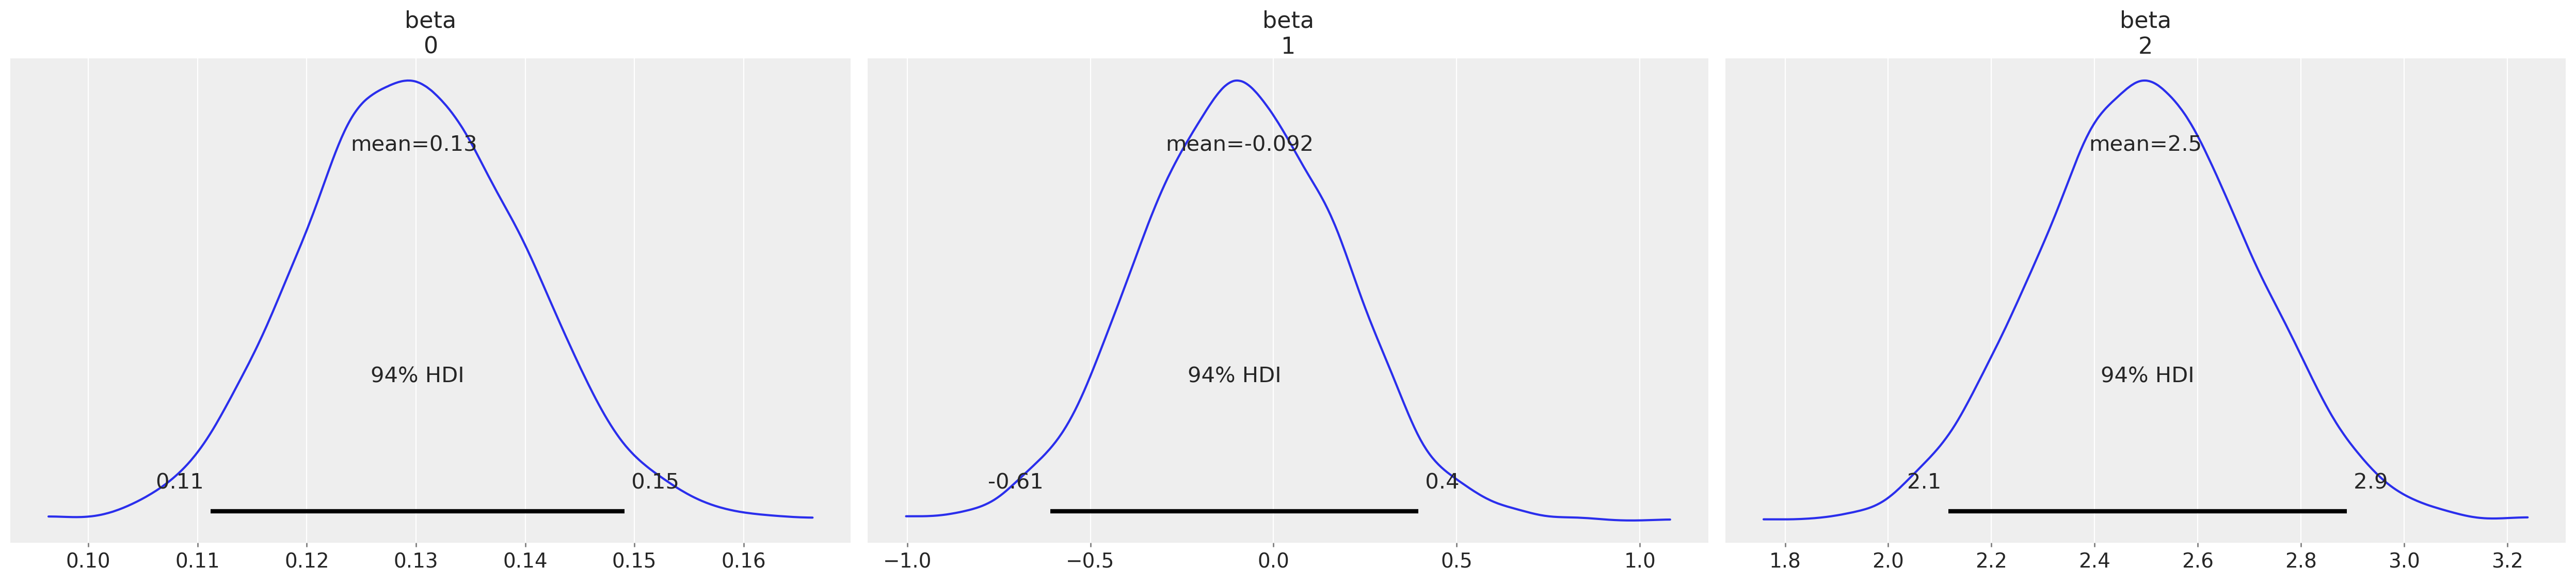

In [20]:
az.plot_posterior(idata3, var_names=["beta"]);

In [21]:
az.summary(idata3, var_names=["cutpoints"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
cutpoints[0]  -1.636  0.793  -3.165   -0.151      0.014    0.011    3097.0   
cutpoints[1]   1.258  0.473   0.431    2.178      0.008    0.005    3980.0   
cutpoints[2]   3.387  0.446   2.602    4.263      0.008    0.005    3412.0   
cutpoints[3]   5.065  0.468   4.147    5.889      0.009    0.006    2907.0   
cutpoints[4]   6.879  0.513   5.930    7.821      0.010    0.007    2625.0   
cutpoints[5]   8.755  0.561   7.748    9.803      0.011    0.008    2486.0   
cutpoints[6]  10.331  0.605   9.222   11.454      0.012    0.008    2544.0   
cutpoints[7]  12.300  0.718  10.999   13.658      0.014    0.010    2728.0   

              ess_tail  r_hat  
cutpoints[0]    2330.0    1.0  
cutpoints[1]    3164.0    1.0  
cutpoints[2]    3427.0    1.0  
cutpoints[3]    3362.0    1.0  
cutpoints[4]    3091.0    1.0  
cutpoints[5]    2896.0    1.0  
cutpoints[6]    2863.0    1.0  
cutpoints[7]    3241.0    1.0

While the parameter estimates seem reasonable and the posterior predictive checks seem good too, the point to see here is that the cutpoints are unconstrained by the definition of the ordinal scale. They vary below 0 in the above model.

However if we look at the model with the constrained Dirchlet prior: 

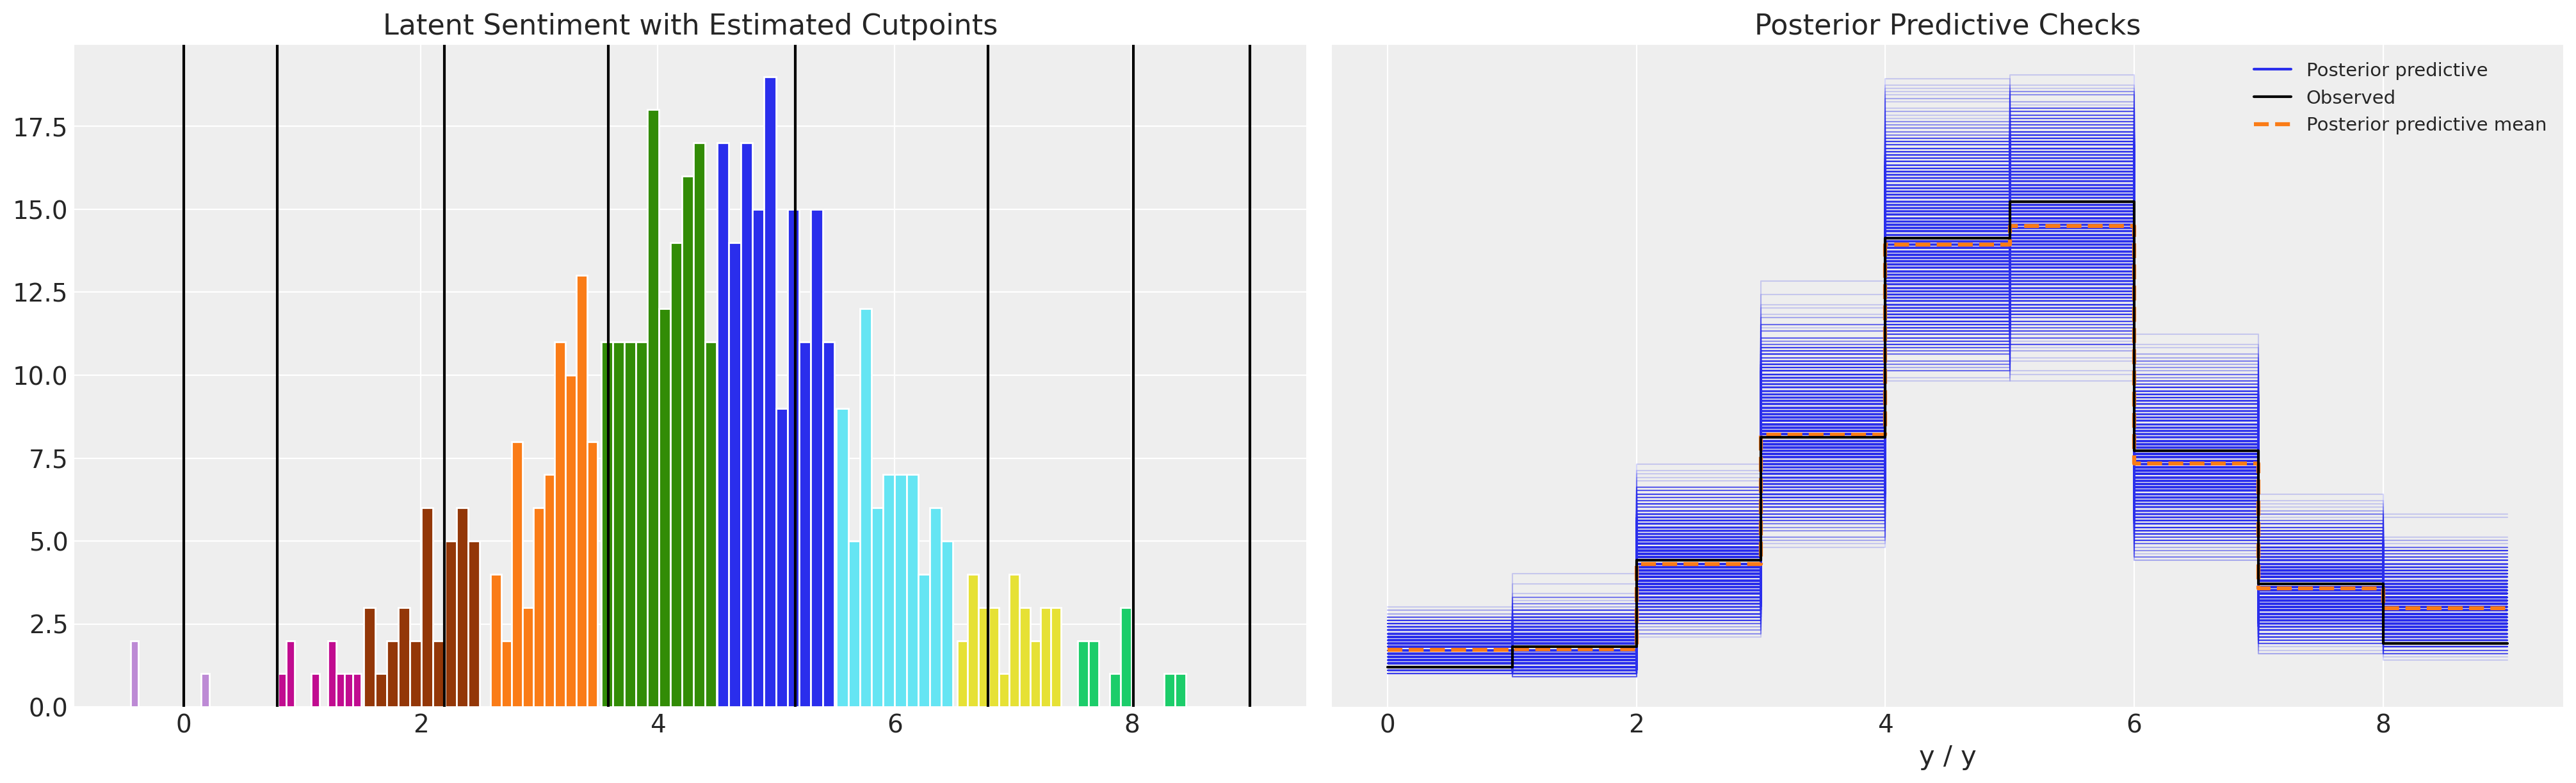

In [22]:
plot_fit(idata4)

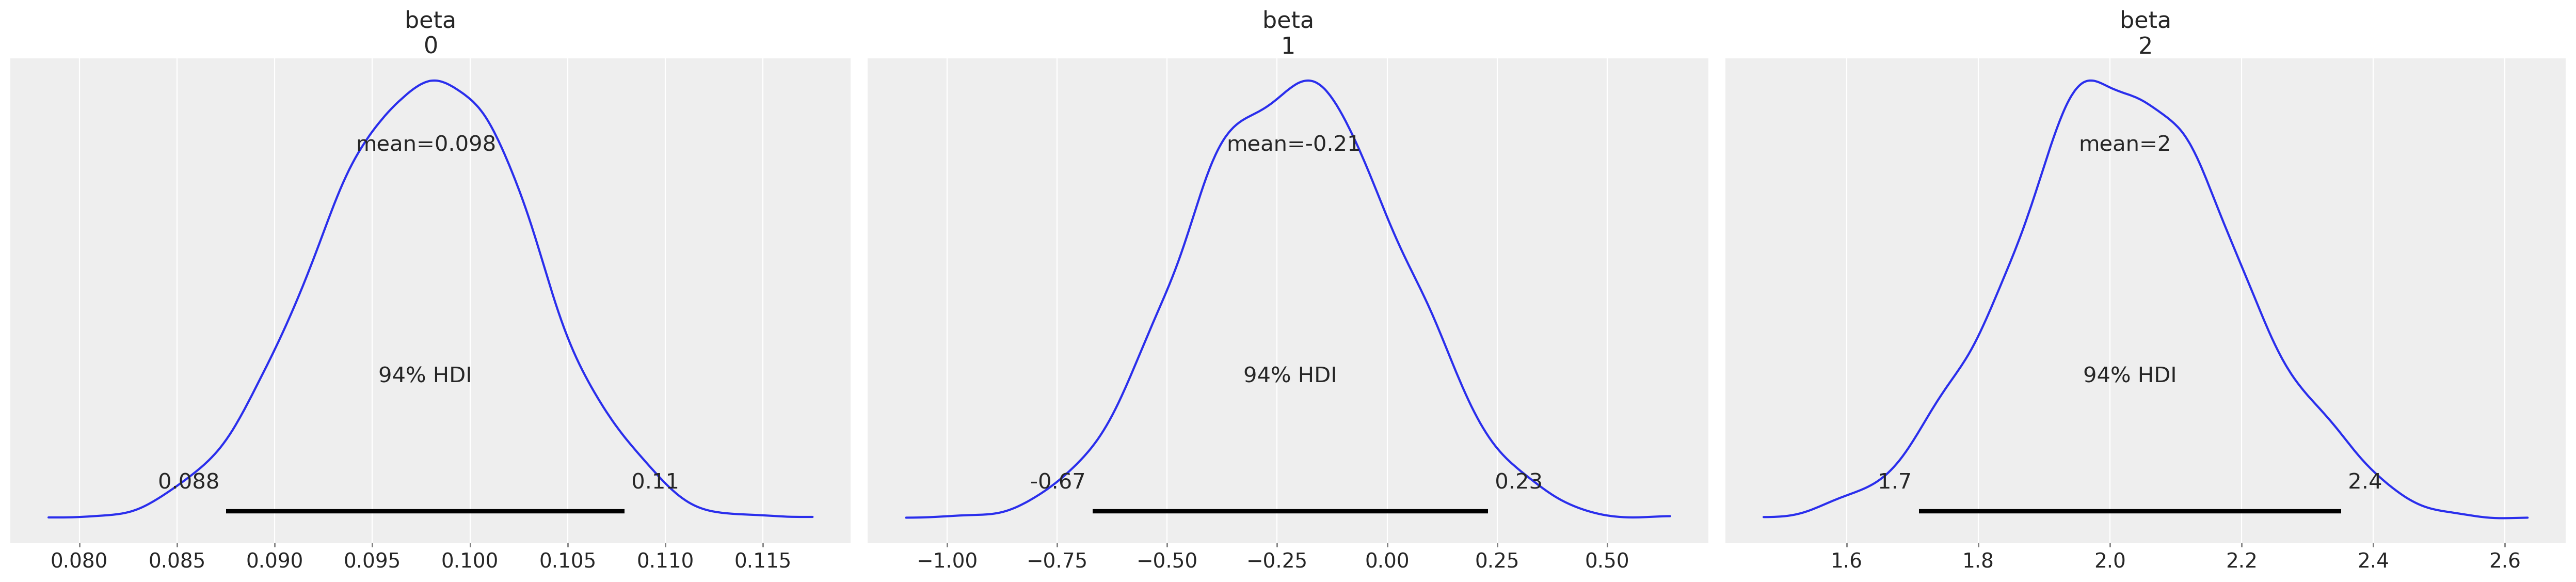

In [23]:
az.plot_posterior(idata4, var_names=["beta"]);

Again the parameters seem reasonable, and posterior predictive checks are sound. But now, having using the constrained uniform prior over the cutpoints our estimated cutpoints respect the definition of the ordinal scale. 

In [24]:
az.summary(idata4, var_names=["cutpoints"])

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
cutpoints[0]  0.000  0.000   0.000    0.000      0.000    0.000    4000.0   
cutpoints[1]  0.790  0.196   0.432    1.162      0.004    0.003    2888.0   
cutpoints[2]  2.198  0.197   1.802    2.543      0.003    0.002    4368.0   
cutpoints[3]  3.583  0.185   3.223    3.913      0.003    0.002    5039.0   
cutpoints[4]  5.161  0.182   4.811    5.495      0.003    0.002    5244.0   
cutpoints[5]  6.790  0.179   6.458    7.128      0.003    0.002    4957.0   
cutpoints[6]  8.013  0.163   7.703    8.299      0.002    0.001    5983.0   
cutpoints[7]  9.000  0.000   9.000    9.000      0.000    0.000    4005.0   

              ess_tail  r_hat  
cutpoints[0]    4000.0    NaN  
cutpoints[1]    1839.0    1.0  
cutpoints[2]    3101.0    1.0  
cutpoints[3]    3203.0    1.0  
cutpoints[4]    3508.0    1.0  
cutpoints[5]    3324.0    1.0  
cutpoints[6]    3222.0    1.0  
cutpoints[7]    3913.0    1.0

## Comparison to Statsmodels

In [25]:
modf_logit = OrderedModel.from_formula(
    "explicit_rating ~ salary + work_sat + work_from_home", df, distr="logit"
)
resf_logit = modf_logit.fit(method="bfgs")
resf_logit.summary()

Optimization terminated successfully.
         Current function value: 1.447704
         Iterations: 59
         Function evaluations: 65
         Gradient evaluations: 65


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:        explicit_rating   Log-Likelihood:                -723.85
Model:                   OrderedModel   AIC:                             1470.
Method:            Maximum Likelihood   BIC:                             1516.
Date:                Wed, 31 May 2023                                         
Time:                        23:07:35                                         
No. Observations:                 500                                         
Df Residuals:                     489                                         
Df Model:                          11                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
salary             0.1349      0.010     13.457      0.000       0.115       0.155
work_sat           0.0564      0.286      0.197      0.844      -0.504       0.617
work_from_home     2.5985      0.206     12.590      0.000       2.194       3.003
-0.0/1.0           0.2158      0.693      0.312      0.755      -1.142       1.573
1.0/2.0            0.5127      0.332      1.543      0.123      -0.138       1.164
2.0/3.0            0.6502      0.161      4.034      0.000       0.334       0.966
3.0/4.0            0.4962      0.108      4.598      0.000       0.285       0.708
4.0/5.0            0.6032      0.080      7.556      0.000       0.447       0.760
5.0/6.0            0.6399      0.076      8.474      0.000       0.492       0.788
6.0/7.0            0.4217      0.113      3.725      0.000       0.200       0.644
7.0/8.0            0.5054      0.186      2.712      0.007       0.140       0.871
==================================================================================
"""

## Interrogating the Model's Implications

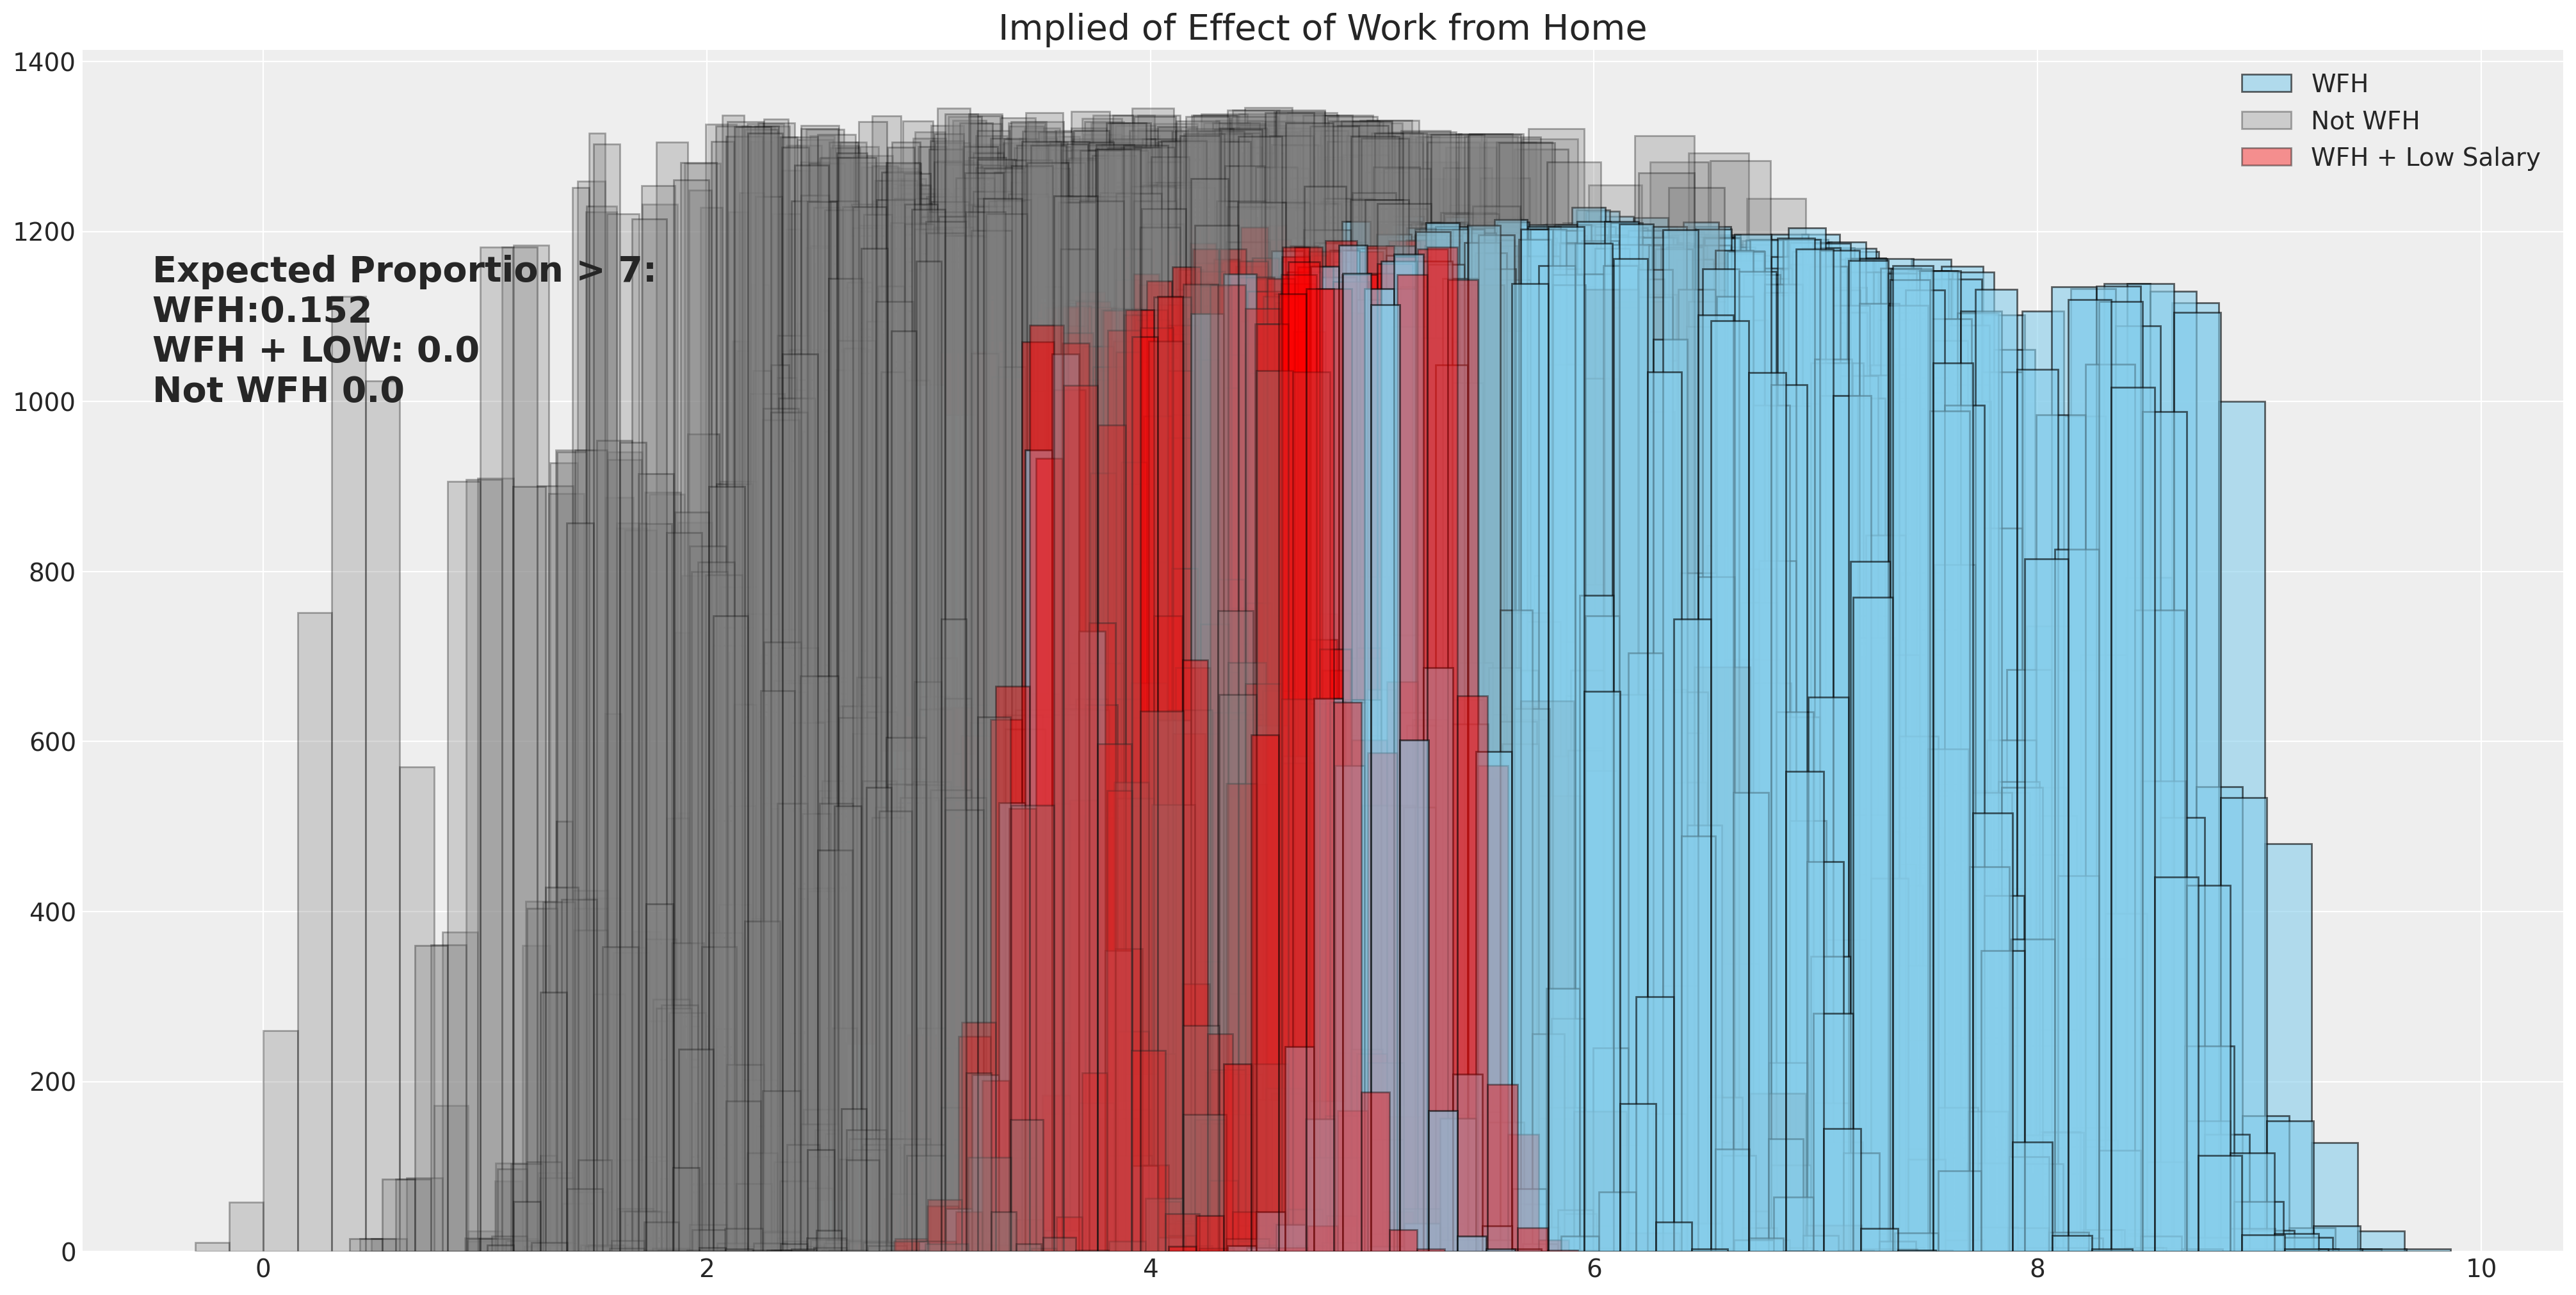

In [26]:
betas_posterior = az.extract(idata4)["beta"]

fig, ax = plt.subplots(figsize=(20, 10))
calc_wfh = [
    df.iloc[i]["salary"] * betas_posterior[0, :]
    + df.iloc[i]["work_sat"] * betas_posterior[1, :]
    + 1 * betas_posterior[2, :]
    for i in range(500)
]
calc_not_wfh = [
    df.iloc[i]["salary"] * betas_posterior[0, :]
    + df.iloc[i]["work_sat"] * betas_posterior[1, :]
    + 0 * betas_posterior[2, :]
    for i in range(500)
]
sal = np.random.normal(25, 5, 500)
calc_wfh_and_low_sal = [
    sal[i] * betas_posterior[0, :]
    + df.iloc[i]["work_sat"] * betas_posterior[1, :]
    + 1 * betas_posterior[2, :]
    for i in range(500)
]

### Use implied threshold on latent score to predict proportion of ratings above 7
prop_wfh = np.sum([np.mean(calc_wfh[i].values) > 6.78 for i in range(500)]) / 500
prop_not_wfh = np.sum([np.mean(calc_not_wfh[i].values) > 6.78 for i in range(500)]) / 500
prop_wfh_low = np.sum([np.mean(calc_wfh_and_low_sal[i].values) > 6.78 for i in range(500)]) / 500

for i in range(500):
    if i == 499:
        ax.hist(calc_wfh[i], alpha=0.6, color="skyblue", ec="black", label="WFH")
        ax.hist(calc_not_wfh[i], alpha=0.3, color="grey", ec="black", label="Not WFH")
        ax.hist(
            calc_wfh_and_low_sal[i], alpha=0.4, color="red", ec="black", label="WFH + Low Salary"
        )
    else:
        ax.hist(calc_wfh[i], alpha=0.6, color="skyblue", ec="black")
        ax.hist(calc_wfh_and_low_sal[i], alpha=0.4, color="red", ec="black")
        ax.hist(calc_not_wfh[i], alpha=0.3, color="grey", ec="black")
ax.set_title("Implied of Effect of Work from Home", fontsize=20)
ax.annotate(
    f"Expected Proportion > 7: \nWFH:{prop_wfh} \nWFH + LOW: {prop_wfh_low} \nNot WFH {prop_not_wfh}",
    xy=(-0.5, 1000),
    fontsize=20,
    fontweight="bold",
)
ax.legend();

## Liddell and Kruschke's IMDB movie Ratings Data

There are substantial reasons for using an ordinal regression model rather than trusting to alternative model specifications. For instance, the temptation to treat the ordered category as a continuous metric will lead to false inferences. The details are discussed in the Liddell and Kruschke paper {cite:p}`LIDDELL2018328` on this topic. We'll briefly replicate their example about how this phenomenon can appear in analysis of movies ratings data.

In [27]:
try:
    movies = pd.read_csv("../data/MoviesData.csv")
except FileNotFoundError:
    movies = pd.DataFrame(pm.get_data("MoviesData.csv"))

In [28]:
def pivot_movie(row):
    row_ratings = row[["n1", "n2", "n3", "n4", "n5"]]
    totals = []
    for c, i in zip(row_ratings.index, range(5)):
        totals.append(row_ratings[c] * [i])
    totals = [item for sublist in totals for item in sublist]
    movie = [row["Descrip"]] * len(totals)
    id = [row["ID"]] * len(totals)
    return pd.DataFrame({"rating": totals, "movie": movie, "movie_id": id})


movies_by_rating = pd.concat([pivot_movie(movies.iloc[i]) for i in range(len(movies))])
movies_by_rating.reset_index(inplace=True, drop=True)
movies_by_rating.shape

(284671, 3)

In [29]:
movies_by_rating.sample(100).head()

rating                                            movie  movie_id
133085       4                                   Bosch Season 3        22
175047       4              The Man in the High Castle Season 1        23
163017       3              The Man in the High Castle Season 1        23
123716       4  Julian Fellowes Presents Doctor Thorne Season 1        20
192631       4              The Man in the High Castle Season 1        23

In [30]:
def constrainedUniform(N, group, min=0, max=1):
    return pm.Deterministic(
        f"cutpoints_{group}",
        pt.concatenate(
            [
                np.ones(1) * min,
                pt.extra_ops.cumsum(pm.Dirichlet(f"cuts_unknown_{group}", a=np.ones(N - 2)))
                * (min + (max - min)),
            ]
        ),
    )

We will fit this data with both an ordinal model and as a metric. This will show how the ordinal fit is subtantially more compelling. 

In [31]:
K = 5
movies_by_rating = movies_by_rating[movies_by_rating["movie_id"].isin([1, 2, 3, 4, 5, 6])]
indx, unique = pd.factorize(movies_by_rating["movie_id"])
priors = {"sigma": 1, "mu": [0, 1], "cut_mu": np.linspace(0, K, K - 1)}


def make_movies_model(ordered=False):
    with pm.Model() as model:

        for g in movies_by_rating["movie_id"].unique():
            if ordered:
                cutpoints = constrainedUniform(K, g, 0, K - 1)
                mu = pm.Normal(f"mu_{g}", 0, 1)
                y_ = pm.OrderedLogistic(
                    f"y_{g}",
                    cutpoints=cutpoints,
                    eta=mu,
                    observed=movies_by_rating[movies_by_rating["movie_id"] == g].rating.values,
                )
            else:
                mu = pm.Normal(f"mu_{g}", 0, 1)
                sigma = pm.HalfNormal(f"sigma_{g}", 1)
                y_ = pm.Normal(
                    f"y_{g}",
                    mu,
                    sigma,
                    observed=movies_by_rating[movies_by_rating["movie_id"] == g].rating.values,
                )

        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}))
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata, model


idata_ordered, model_ordered = make_movies_model(ordered=True)
idata_normal_metric, model_normal_metric = make_movies_model(ordered=False)

Sampling: [cuts_unknown_1, cuts_unknown_2, cuts_unknown_3, cuts_unknown_4, cuts_unknown_5, cuts_unknown_6, mu_1, mu_2, mu_3, mu_4, mu_5, mu_6, y_1, y_2, y_3, y_4, y_5, y_6]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:04.948946
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:09.375610
Transforming variables...
Transformation time =  0:00:00.430104
Computing Log Likelihood...


Sampling: [y_1, y_2, y_3, y_4, y_5, y_6]


Log Likelihood time =  0:00:01.431385


Sampling: [mu_1, mu_2, mu_3, mu_4, mu_5, mu_6, sigma_1, sigma_2, sigma_3, sigma_4, sigma_5, sigma_6, y_1, y_2, y_3, y_4, y_5, y_6]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.264569
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.698786
Transforming variables...
Transformation time =  0:00:00.008659
Computing Log Likelihood...


### Posterior Predictive Fit: Normal Metric Model

This is a horrific fit to the movies rating data for six movies.

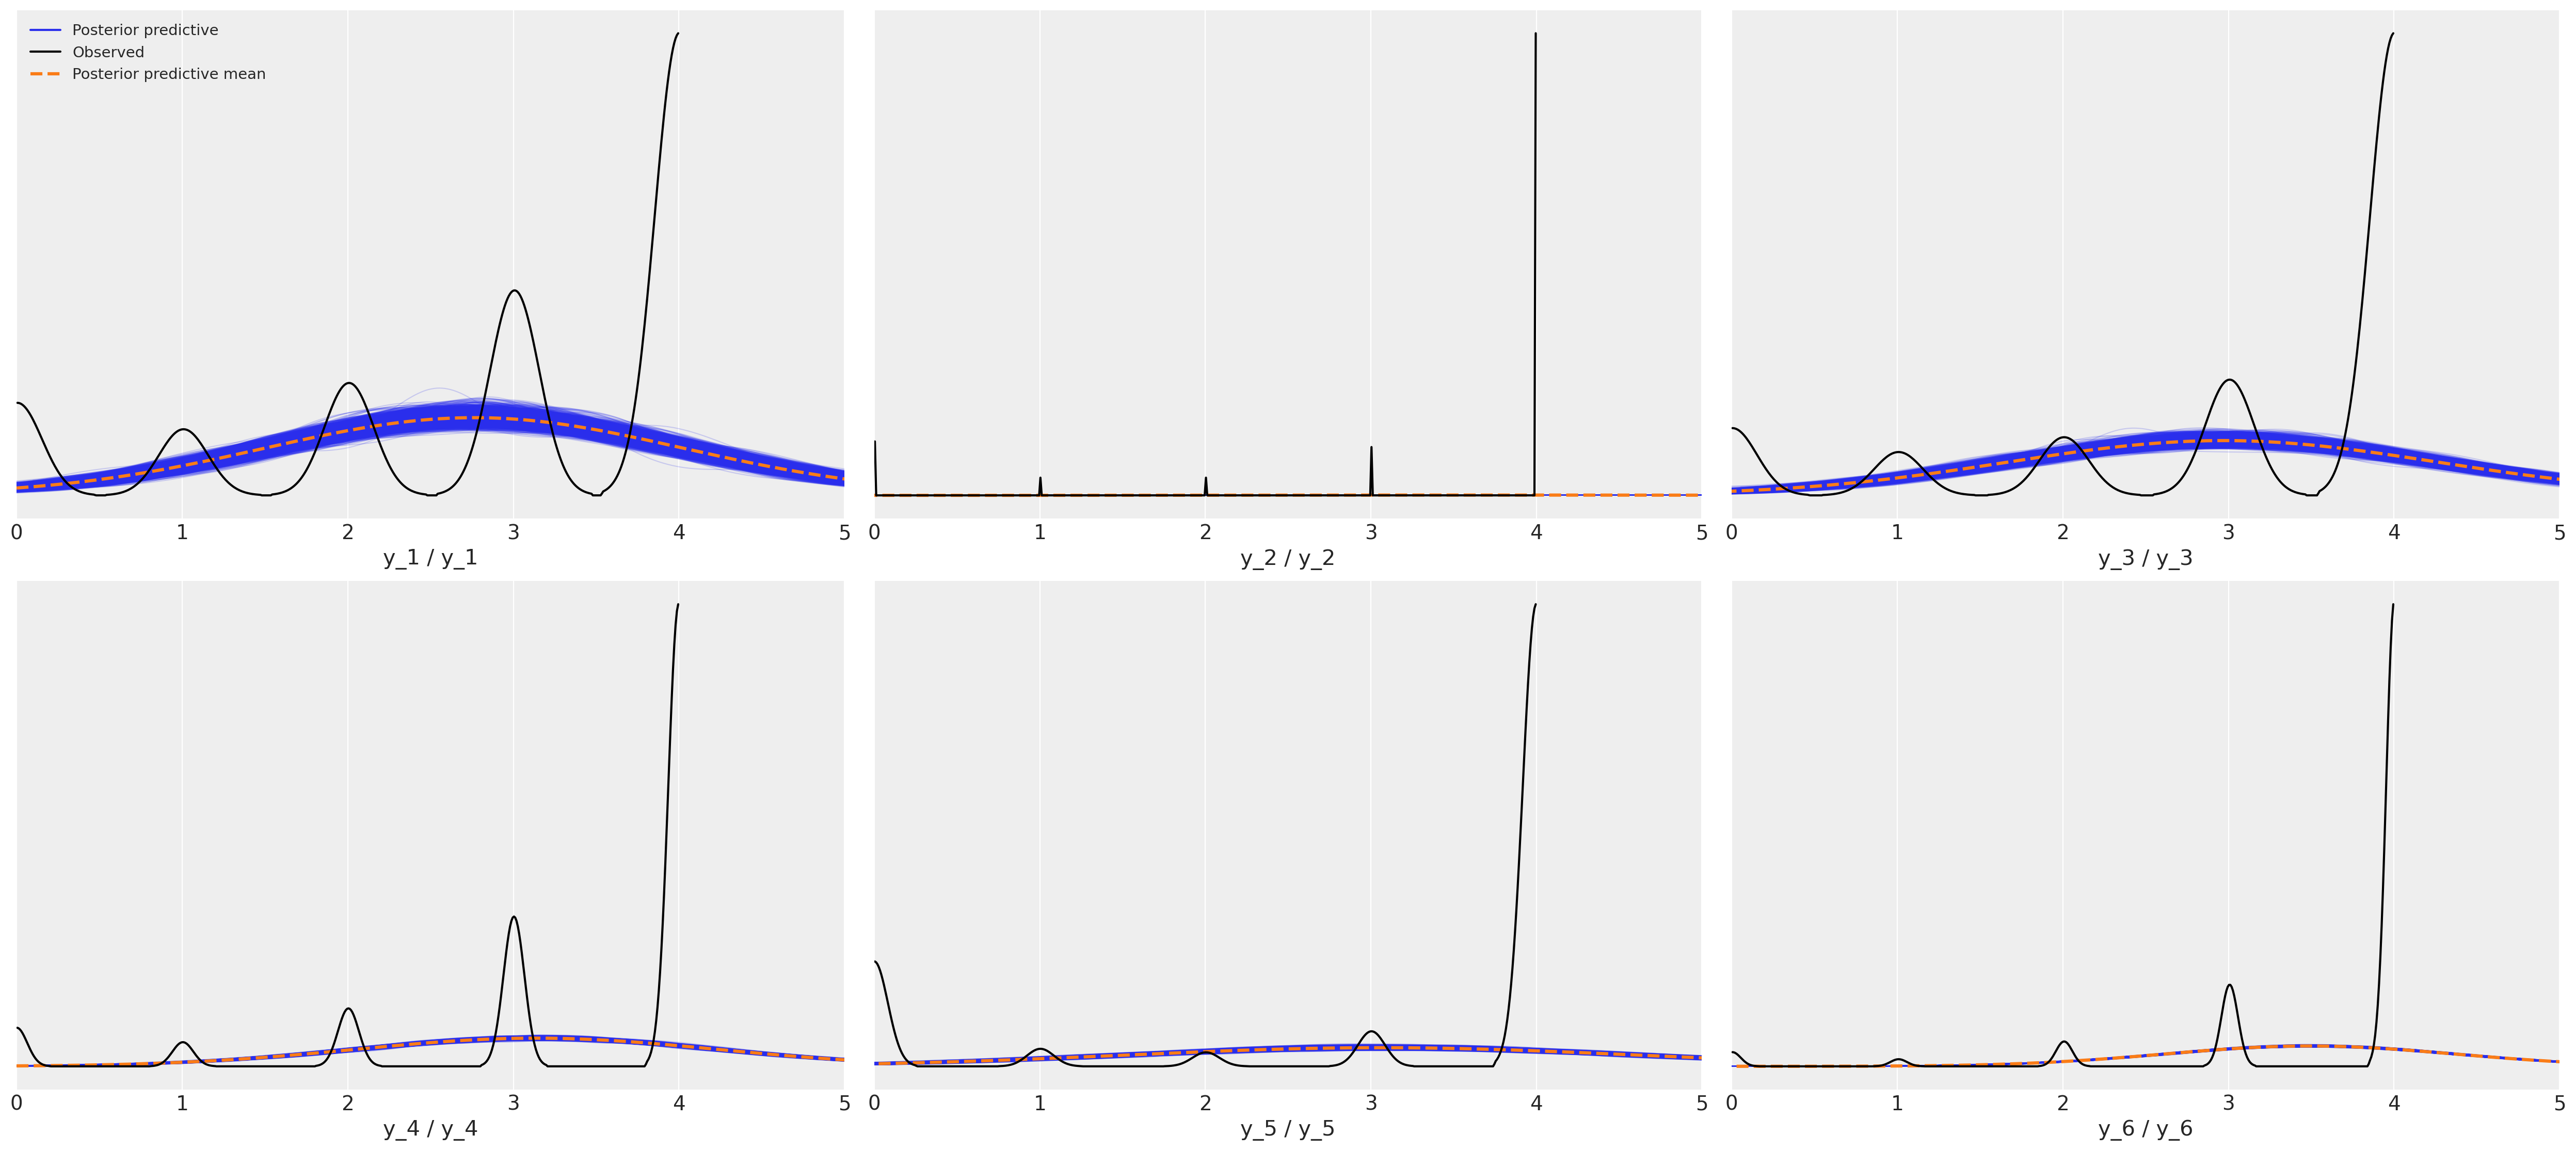

In [32]:
axs = az.plot_ppc(idata_normal_metric)
axs = axs.flatten()
for ax in axs:
    ax.set_xlim(0, 5);

### Posterior Predictive Fit: Ordered Response Model

This shows a much nicer fit for each of the six movies. 

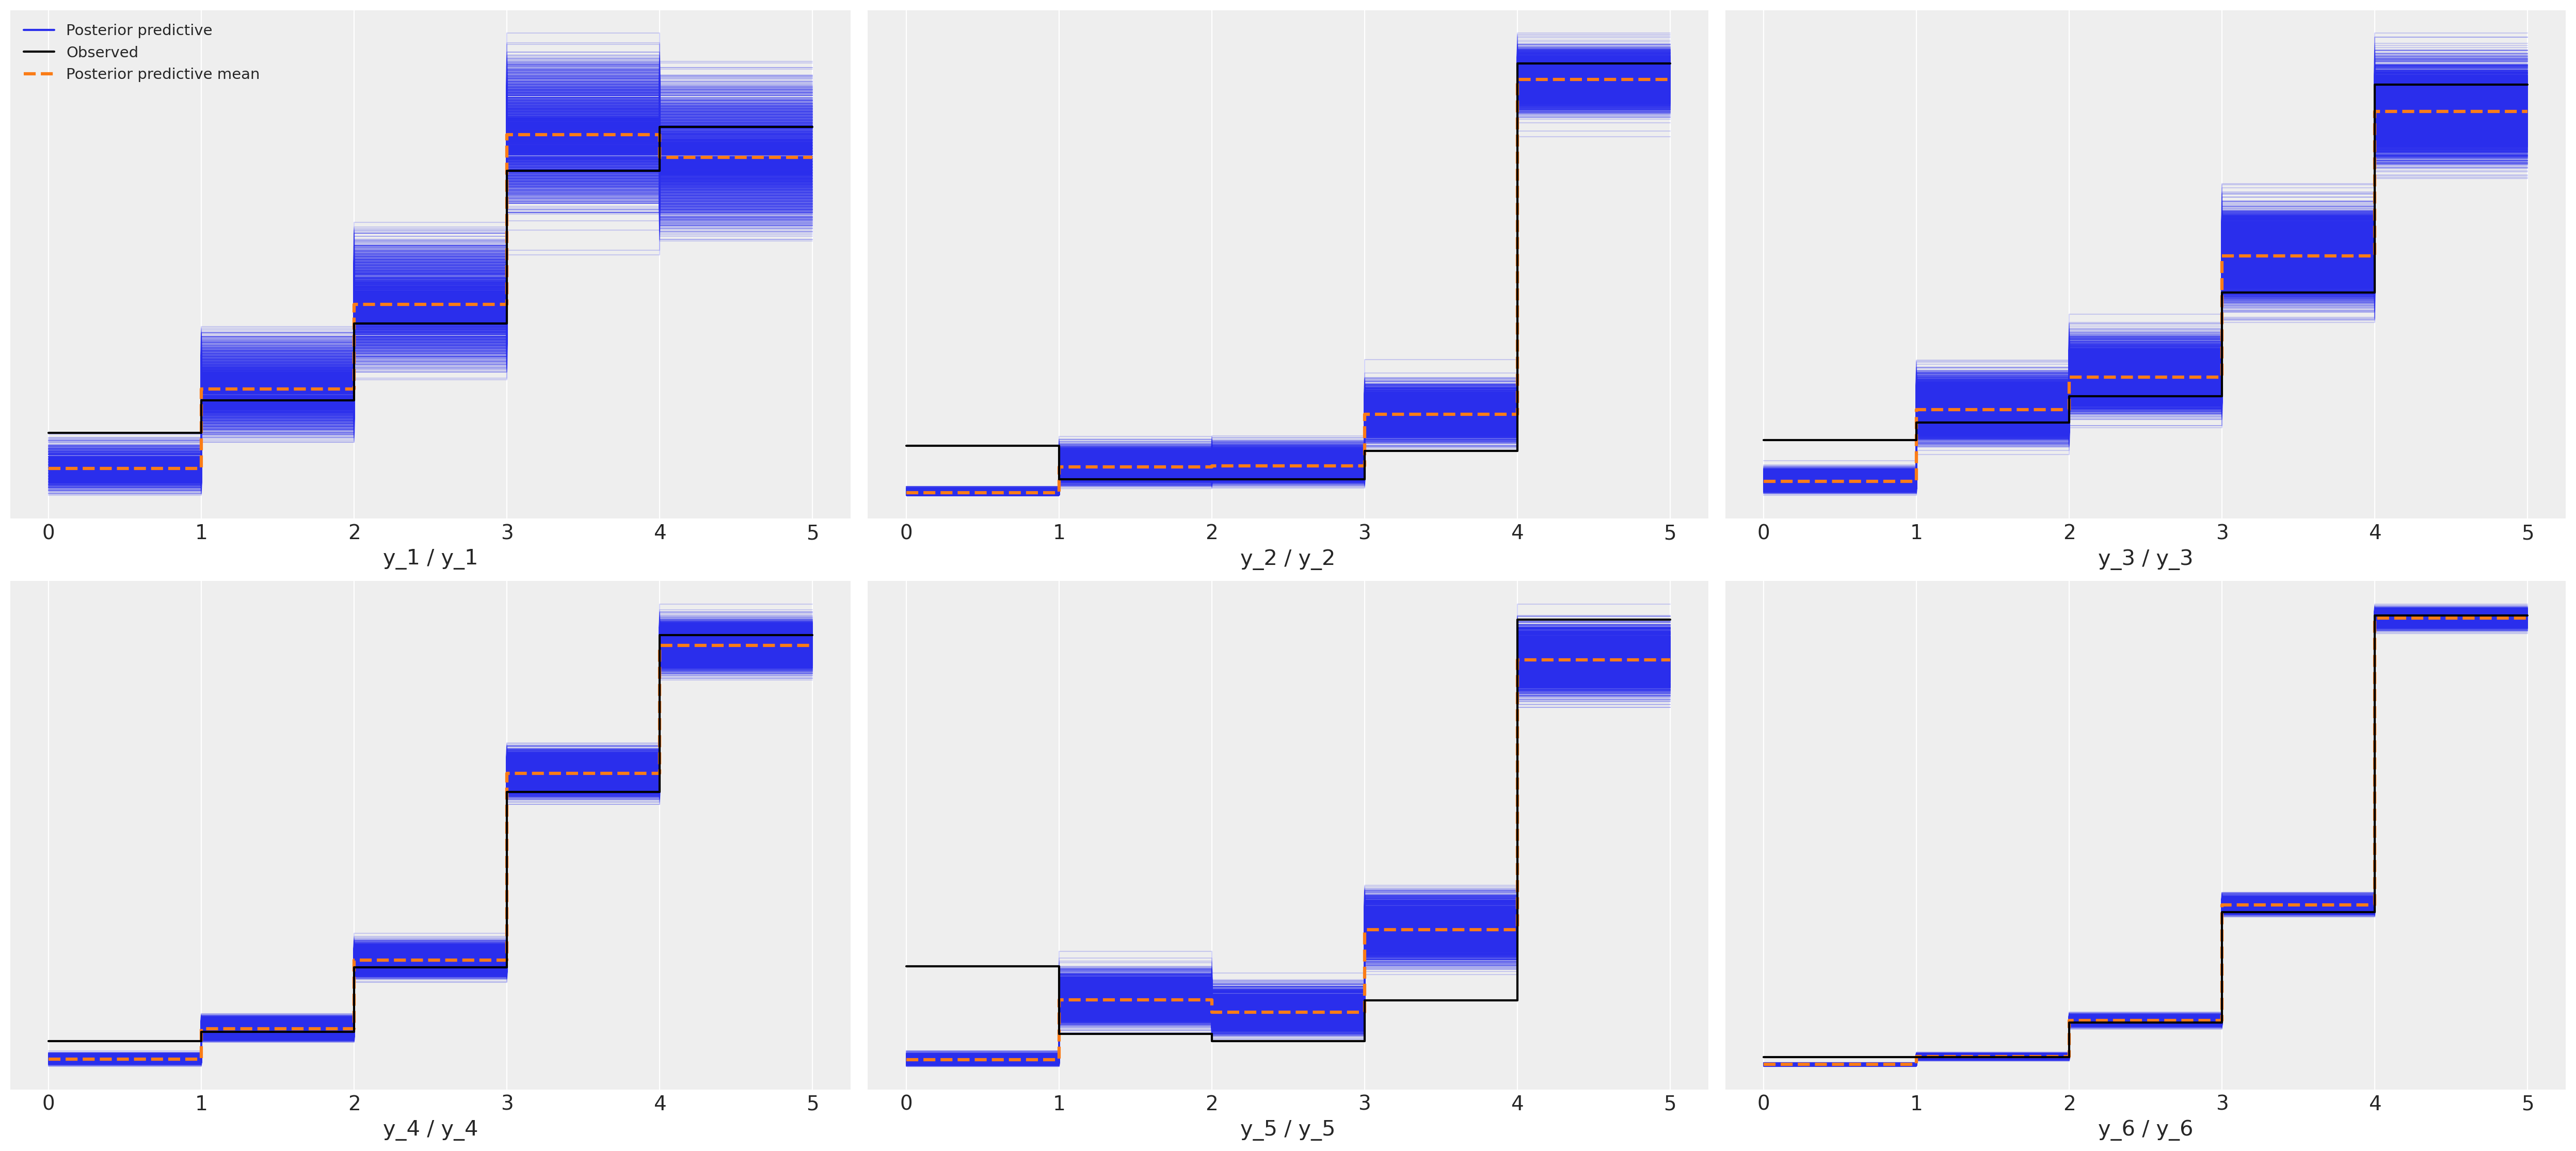

In [33]:
az.plot_ppc(idata_ordered);

Since this is real data and we don't know the true data generating process it's impossible to say which is the correct model but I hope you'll agree that the posterior predictive checks strongly support the claim that the ordered categorical fit is a stronger candidate. The simpler point to make here is just that the implications of the metric models are wrong and if we hope to make sound inferences about what perhaps drives good movie ratings, then we'd better be sure not to introduce noise into the modelling exercise with a poor choice of likelihood function. 

### Compare Model Fits

In [34]:
y_5_compare = az.compare({"ordered": idata_ordered, "metric": idata_normal_metric}, var_name="y_5")
y_5_compare

rank     elpd_loo     p_loo   elpd_diff        weight         se  \
ordered     0 -1651.366653  3.578402    0.000000  1.000000e+00  48.863108   
metric      1 -2191.412062  1.878041  540.045409  2.220446e-16  24.046527   

               dse  warning scale  
ordered   0.000000    False   log  
metric   28.219954    False   log

In [35]:
y_6_compare = az.compare({"ordered": idata_ordered, "metric": idata_normal_metric}, var_name="y_6")
y_6_compare

rank      elpd_loo     p_loo    elpd_diff  weight          se  \
ordered     0 -13339.274789  3.126878     0.000000     1.0  110.342900   
metric      1 -17723.258047  4.302780  4383.983258     0.0  148.692301   

               dse  warning scale  
ordered   0.000000    False   log  
metric   85.842735    False   log

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

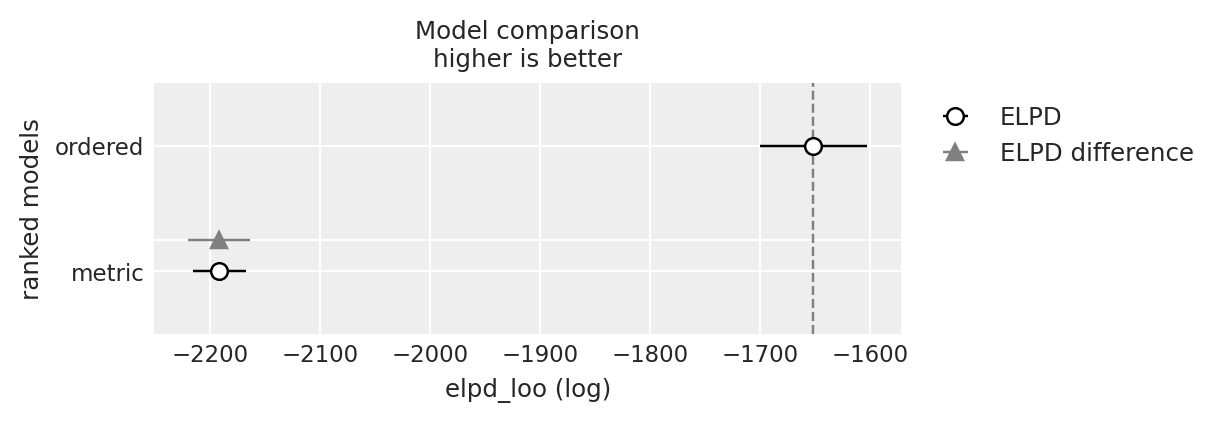

In [36]:
az.plot_compare(y_5_compare)

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

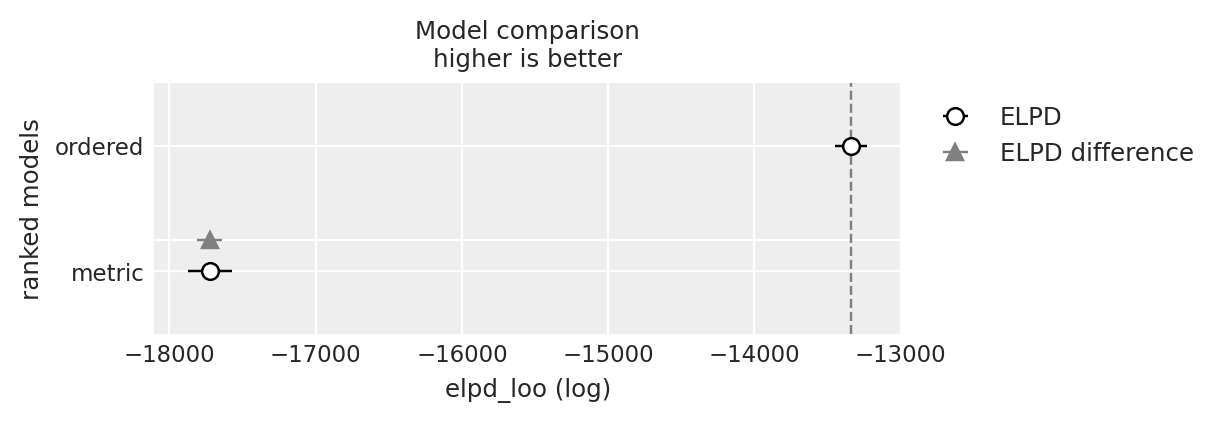

In [37]:
az.plot_compare(y_6_compare)

### Compare Inferences between Models

Aside from the predictive fits, the inferences drawn from the different modelling choices also vary quite significantly. Imagine being a movie executive trying to decide whether to commit to a sequel, then relative movie performance rating against competitor  benchmarks might be a pivotal feature of this decision, and difference induced by the analyst's choice of model can have an outsized effect on that choice. 

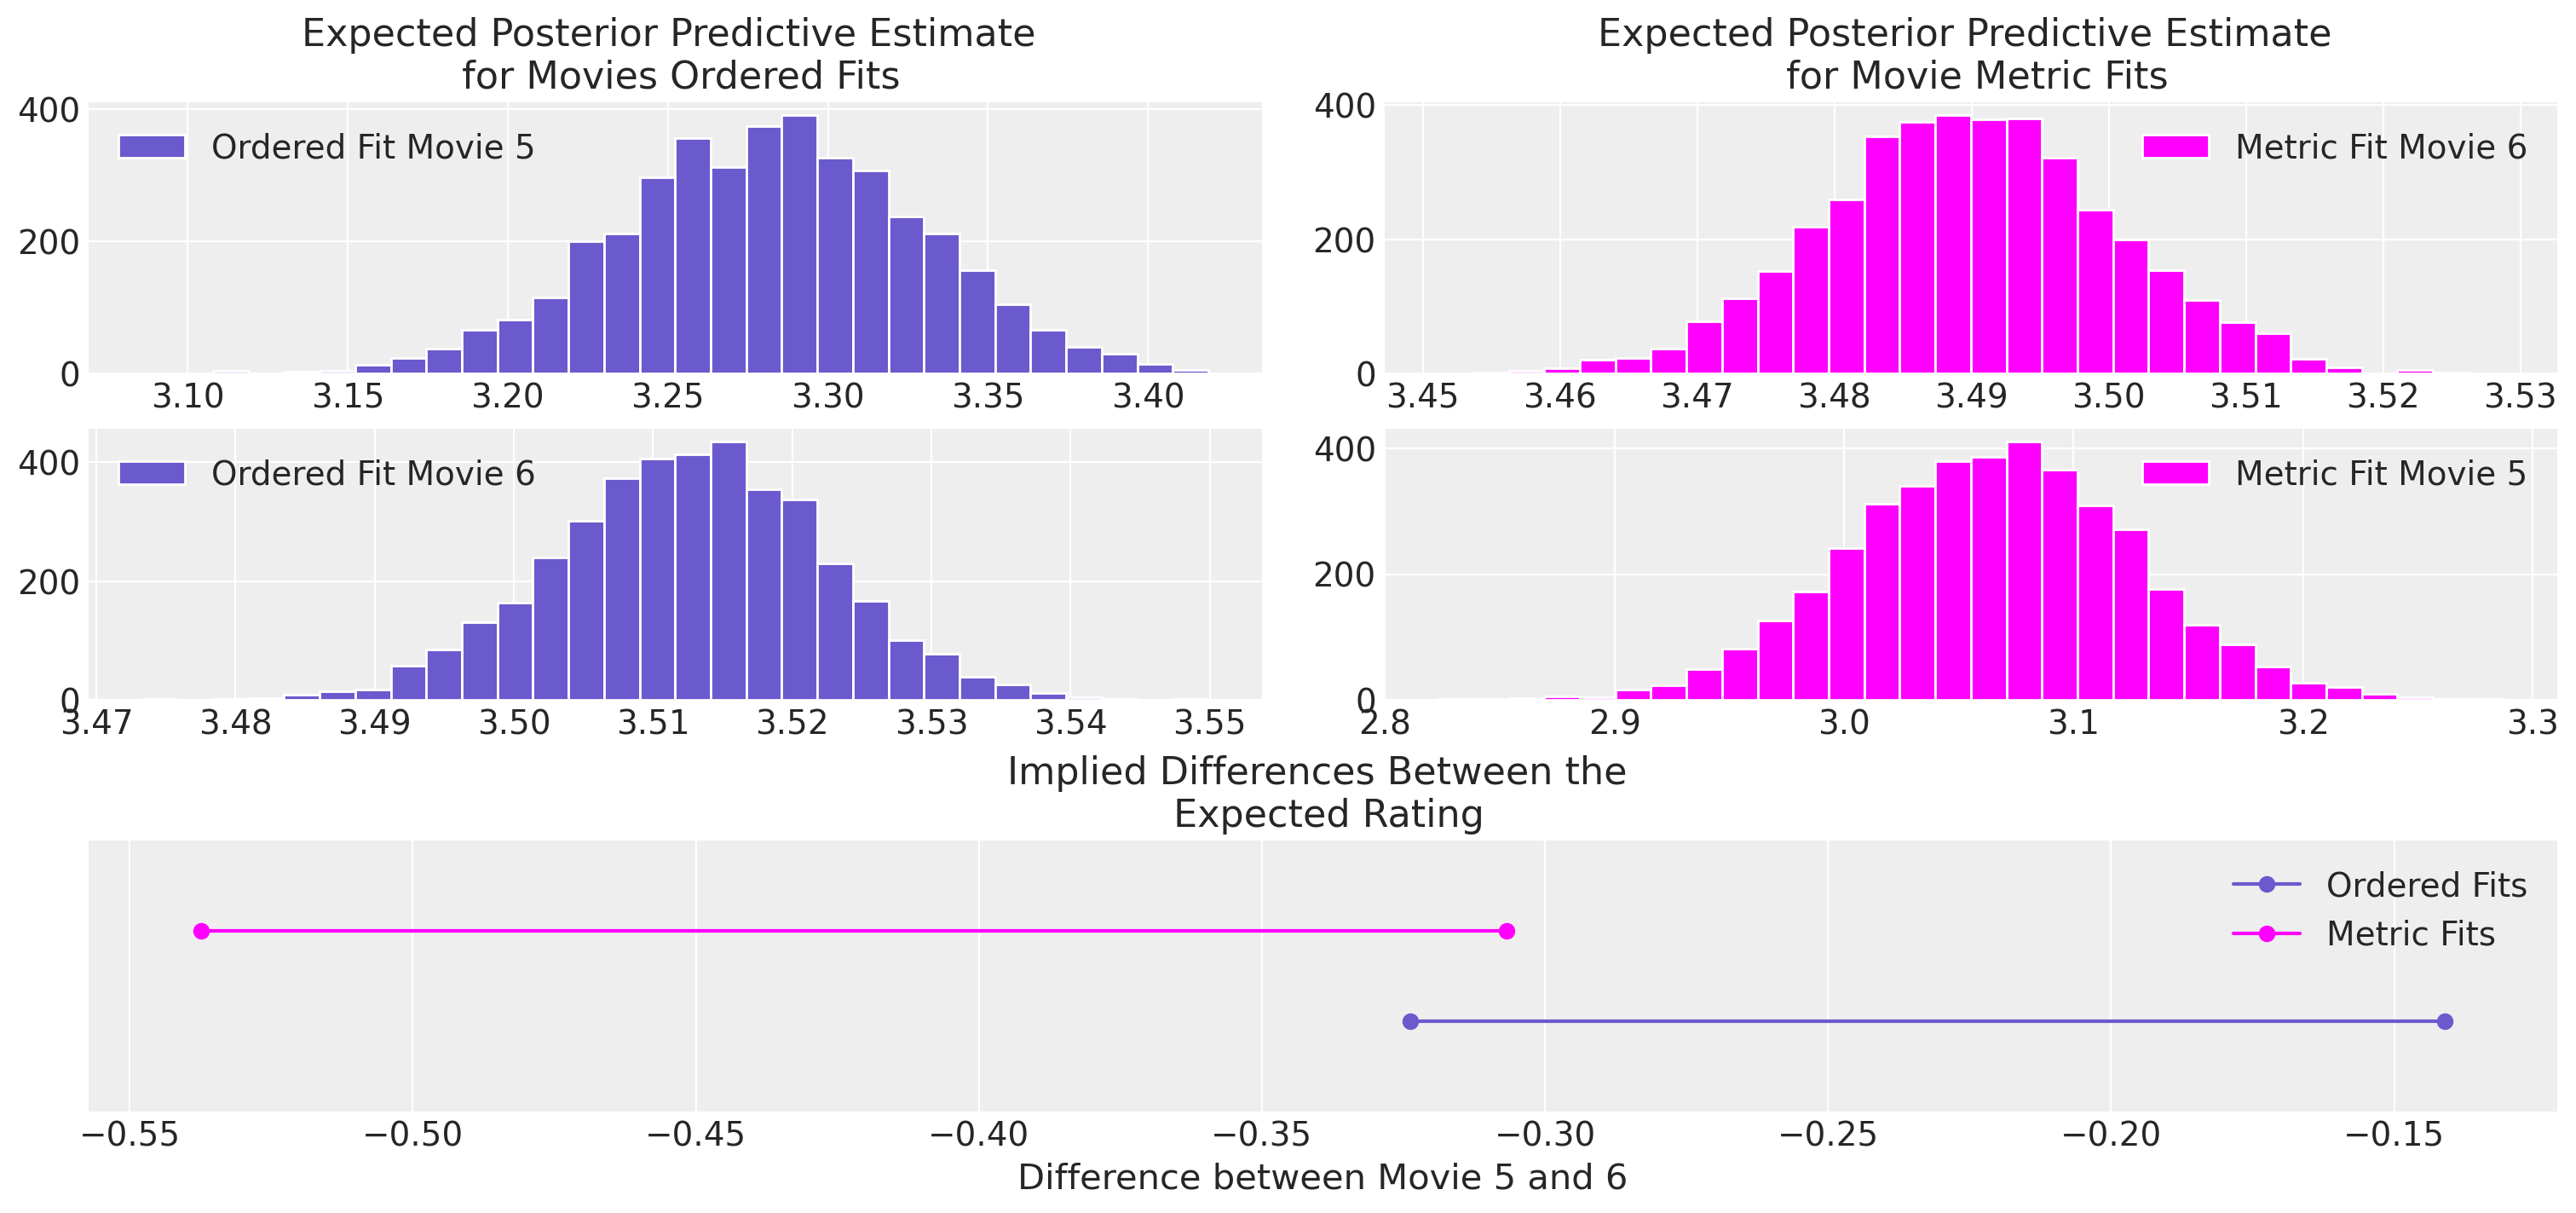

In [38]:
mosaic = """
AC
DE
BB
"""
fig, axs = plt.subplot_mosaic(mosaic, figsize=(15, 7))
axs = [axs[k] for k in axs.keys()]
axs
ordered_5 = az.extract(idata_ordered.posterior_predictive)["y_5"].mean(axis=0)
ordered_6 = az.extract(idata_ordered.posterior_predictive)["y_6"].mean(axis=0)
diff = ordered_5 - ordered_6
metric_5 = az.extract(idata_normal_metric.posterior_predictive)["y_5"].mean(axis=0)
metric_6 = az.extract(idata_normal_metric.posterior_predictive)["y_6"].mean(axis=0)
diff1 = metric_5 - metric_6
axs[0].hist(ordered_5, bins=30, ec="white", color="slateblue", label="Ordered Fit Movie 5")
axs[4].plot(
    az.hdi(diff.unstack())["x"].values, [1, 1], "o-", color="slateblue", label="Ordered Fits"
)
axs[4].plot(
    az.hdi(diff1.unstack())["x"].values, [1.2, 1.2], "o-", color="magenta", label="Metric Fits"
)
axs[2].hist(ordered_6, bins=30, ec="white", color="slateblue", label="Ordered Fit Movie 6")
axs[3].hist(metric_5, ec="white", label="Metric Fit Movie 5", bins=30, color="magenta")
axs[1].hist(metric_6, ec="white", label="Metric Fit Movie 6", bins=30, color="magenta")
axs[4].set_title("Implied Differences Between the \n Expected Rating")
axs[4].set_ylim(0.8, 1.4)
axs[4].set_yticks([])
axs[0].set_title("Expected Posterior Predictive Estimate \n for Movies Ordered Fits")
axs[1].set_title("Expected Posterior Predictive Estimate \n for Movie Metric Fits")
axs[4].set_xlabel("Difference between Movie 5 and 6")
axs[1].legend()
axs[0].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend();

There are many millions of dollars on the line when making the decision to put a movie into production. The return on that investment is a least partially a function of the movie's popularity which is both measured and influenced by the rating scales on Rotten Tomatoes and IMDB. Understanding the relative popularity of different movies therefore can shift huge amounts of money through hollywood, and the implied differences seen here really do matter. Similar considerations follow for considering more significant rating scales which measure happiness and depression. 

# Conclusion

In this notebook we've seen how to build ordinal regression models with PyMC and motivated the modelling exercise using the interpretation of ordinal outcomes as the discrete outcomes of a latent continuous phenomena. We've seen how different model specifications can generate more or less interpretable estimates of the parameters underlying the model. We've also compared the ordinal regression approach to a more naive regression approach on ordinal data. The results strongly suggest that the ordinal regression avoids some of the inferential pitfalls that occur with the naive approach. In addition we've shown that the flexibility of the bayesian modelling work flow can provide assurances against the risk of model misspecification making it a viable and compelling approach for the analysis of ordinal data. 

## Authors
- Authored by [Nathaniel Forde](https://github.com/NathanielF) in May 2023 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [39]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed May 31 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.11.0

pytensor: 2.11.1

pytensor   : 2.11.1
statsmodels: 0.13.5
matplotlib : 3.7.1
numpy      : 1.23.5
pymc       : 5.3.0
pandas     : 1.5.3
arviz      : 0.15.1

Watermark: 2.3.1



:::{include} ../page_footer.md
:::